# v3_cordC_syne.ipynb

A copy of v3_cordC where the spinal circuit has the synergetic configuration
(each `AL` unit stimulates two muscles)

In [1]:
%cd ../..
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from multiprocessing import Pool

/home/z/projects/draculab


In [2]:
%load_ext Cython

In [3]:
%%cython
from draculab import *
from plants import spinal_plants

In [4]:
# load a parameter configuration
#fname = '/home/z/Dropbox (OIST)/saves/gene_2021-07-19'
# fname = '/home/z/Dropbox (OIST)/saves/gene_2022-06-20'
# with (open(fname, "rb")) as f:
#     pop = pickle.load(f)
#     f.close()   
#cfg = pop[0]

# The C_LEARNS_SYNE config from reach_analysis_C
cfg = { 'A__C_lrate': 22.5,
            'A__C_w_max_frac': 0.17785757836500374,
            'A__C_w_sum': 1.5489290867328447,
            'A__M_lrate': 26.17,
            'A__M_w_max_frac': 0.47055115331365194,
            'A__M_w_sum': 0.5269733904869145,
            'AL_thresh': 1.1,
            'b_e': 1.0,
            'C__C_antag': 1.83,
            'C__C_p_antag': 0.16,
            'C__C_p_syne': 0.18,
            'C__C_syne': 0.5,
            'C_adapt_amp': 3.1,
            'C_cid': 0.3605638288606652,
            'C_sigma': 0.6859027781213456,
            'C_slope': 3.3846358891215536,
            'C_tau': 0.17765185440952685,
            'C_tau_slow': 11.0,
            'CE_thresh': 2.313076428241504,
            'CE__CI_w': 0.5,
            'CI__CE_w': -1.8,
            'CI_slope': 2.4584136116648474,
            'CI_tau': 0.018,
            'CI_thresh': 1.7224417122615483,
            'g_e_03': 22.37,
            'g_e_factor': 3.0,
            'II_g_03': 7.46,
            'k_pe_e': 20.0,
            'k_se_e': 20.0,
            'M__AL_lrate': 300.0,
            'M__AL_w_sum': 2.86,
            'M__C_lrate': 500.0,
            'M__C_w_sum': 3.694337688927602,
            'M__M_w': -1.1363982590380328,
            'M_cid': 0.94,
            'M_des_out_w_abs_sum': 2.52,
            'M_tau': 0.047,
            'M_slope': 2.246355953968214,
            'M_thresh': 1.19421607748966,
            'M_sigma': 0.45,
            'SF_thresh_03': 0.75,
            'SPF__M_lrate': 0.0,
            'SPF__M_w_sum': 3.989179382884881,
            'SPF_des_out_w_abs_sum': 3.23,
            'SPF__SPF_w': -1.77,
            'fitness': 0.02223527862809177,
            'n_evals': 1,
            't_pres': 40.0,
            'par_heter': 0.01,
            'SF_slope': 3.0,
            'SPF_M_lrate': 500.0 }

C_noise = False # whether C units are noisy (use euler_maru integrator)
par_heter = cfg['par_heter']

In [5]:
def create_net(coords):
    """ Create a network with a hand in the given coordinates.
    
    Args:
        coords: list-like with [x,y] coordinates.
        
    Returns:
        net: a network where the initial hand position is the given coordinates.
        pops_dict: a dictionary with the names and unit IDs for all populations. 
    """

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # network and plant parameters
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    net_params = {'min_delay' : 0.005,
                  'min_buff_size' : 8 }
    # Find the angles corresponding to the given coordinates
    L1 =0.3  # upper arm length to create initial angles
    L2 = 0.3 # forearm length
    # copied from coords_to_angs
    x = coords[0]
    y = coords[1]
    Rsq = x*x + y*y
    R = np.sqrt(Rsq)
    if R > L1 + L2:
        raise ValueError('Unreachable coordinate given')
    qe = np.pi - np.arccos((L1**2 + L2**2 - Rsq) / (2.*L1*L2))
    qs = np.arctan2(y,x) - np.arcsin((L2/R)*np.sin(qe))
    P_params = {'type' : plant_models.bouncy_planar_arm_v3,
              'mass1': 1.,
              'mass2': 1.,
              's_min' : -0.8,
              'p1' : (-0.01, 0.04),
              'p2' : (0.29, 0.03),
              'p3' : (0., 0.05),
              'p4' : (0.1, 0.04),
              'p5' : (0.01, -0.05),
              'p6' : (0.11, -0.04),
              'p10': (0.29, 0.03),
              'init_q1': qs,
              'init_q2': qe,
              'init_q1p': 0.,
              'init_q2p': 0.,
              'g': 0.0,
              'mu1': 3.,
              'mu2': 3.,
              'l_torque' : 0.01,
              'l_visco' : 0.01,
              'g_e' : cfg['g_e_factor']*np.array([cfg['g_e_03'], 20., 20.,
                                                  cfg['g_e_03'], 22., 23.]),
              'l0_e' : [1.]*6,
              'Ia_gain' : 2.5*np.array([3.,10.,10., 3.,11.,11.]),
              'II_gain' : 2.*np.array([cfg['II_g_03'], 8., 8.,
                                       cfg['II_g_03'], 8., 8.]),
              'Ib_gain' : 1.,
              'T_0' : 10.,
              'k_pe_e' : cfg['k_pe_e'], #8
              'k_se_e' : cfg['k_se_e'], #13
              'b_e' : cfg['b_e'],
              'g_s' : 0.02,
              'k_pe_s' : 2., 
              'k_se_s' : 2.,
              'g_d' : 0.01,
              'k_pe_d' : .2, #.1,
              'k_se_d' : 1., #2.,
              'b_s' : .5,
              'b_d' : 2.,#3.,
              'l0_s': .7,
              'l0_d': .8,
              'fs' : 0.1,
              'se_II' : 0.5,
              'cd' : 0.5,
              'cs' : 0.5,
              'tau' : 0.1   # ficticious time constant used in create_freqs_steps
               }
    
    net = network(net_params) # create network

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # UNIT PARAMETER DICTIONARIES
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    randz = lambda n: (1. + par_heter*(np.random.rand(n)-0.5))

    AL_params = {'type' : unit_types.sigmoidal,
                 'thresh' : cfg['AL_thresh'] * randz(6),
                 'slope' : 2. * randz(6),
                 'init_val' : 0.1 * randz(6),
                 'tau' : 0.02 * randz(6) }
    SYNE_params = {'type' : unit_types.rga_adapt_sig,
                'integ_meth' : 'euler_maru' if C_noise else 'odeint',
                'init_val' : [r*np.array([0.5]) for r in np.random.random(12)],
                'multidim' : False,
                'slope' : cfg['C_slope'],
                'thresh' : cfg['CE_thresh'] if 'CE_thresh' in cfg else cfg['C_thresh'],
                'tau' : cfg['C_tau'],
                'tau_fast': 0.01,
                'tau_mid' : 0.05,
                'tau_slow' : cfg['C_tau_slow'],
                'custom_inp_del' : int(round(cfg['C_cid']/net_params['min_delay'])),
                'delay' : 0.31, # to be set below
                'adapt_amp' : cfg['C_adapt_amp'],
                'mu' : 0.,
                'sigma' : cfg['C_sigma'] }
    SYNI_params = {'type' : unit_types.rga_adapt_sig,
                'integ_meth' : 'euler_maru' if C_noise else 'odeint',
                'init_val' : [r*np.array([0.5]) for r in np.random.random(12)],
                'multidim' : False,
                'slope' : cfg['CI_slope'] if 'CI_slope' in cfg else cfg['C_slope'],
                'thresh' : cfg['CI_thresh'] if 'CI_thresh' in cfg else cfg['C_thresh'],
                'tau' :  cfg['CI_tau'] if 'CI_tau' in cfg else cfg['C_tau'],
                'tau_fast': 0.01,
                'tau_mid' : 0.05,
                'tau_slow' : cfg['C_tau_slow'],
                'custom_inp_del' : int(round(cfg['C_cid']/net_params['min_delay'])),
                'delay' : 0.31, # to be set below
                'adapt_amp' : cfg['C_adapt_amp'],
                'mu' : 0.,
                'sigma' : cfg['C_sigma'] }
    INP_params = {'type' : unit_types.source,
                  'init_val' : 0.5,
                  'tau_fast' : 0.02,
                  'tau_mid' : 0.1,
                  'function' : lambda t: None }
    track_params = {'type' : unit_types.source,
                    'init_val' : 0.02,
                    'function' : lambda t: None }

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CONNECTION DICTIONARIES
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # AL to P ------------------------------------------------
    AL__P_conn = {'inp_ports' : list(range(6)),
                 'delays': 0.02 }
    AL__P_syn = {'type': synapse_types.static,
                'init_w' : 1. }
    # synergy units to alpha units
    SYNE__AL_conn = {'rule' : 'all_to_all',
                     'delay' : 0.01 }
    SYNE__AL_syn = {'type' : synapse_types.static,
                    'inp_ports':2,
                    'init_w' : 1. }
    SYNI__AL_conn = {'rule' : 'all_to_all',
                     'delay' : 0.01 }
    SYNI__AL_syn = {'type' : synapse_types.static,
                    'inp_ports':2,
                    'init_w' : -1. }
    # Connections between SYNE and SYNI
    SYNE__SYNI_conn = {'rule' : 'one_to_one',
                       'delay' : 0.01 }
    SYNI__SYNE_conn = {'rule' : 'one_to_one',
                       'delay' : 0.01 }
    SYNE__SYNI_syn = {'type' : synapse_types.static,
                      'inp_ports' : 1,
                      'init_w' : cfg['CE__CI_w'] }
    SYNI__SYNE_syn = {'type' : synapse_types.static, #static, #corr_inh,
                      'inp_ports' : 1,
                      'init_w' : cfg['CI__CE_w'] }
    SYN_antag_conn = {'rule': 'one_to_one',
                      'allow_autapses' : False,
                      'delay' : 0.01 }
    SYN_antag_syn = {'type' : synapse_types.static,
                      'inp_ports': 1, # "lateral" port of rga_21 synapses
                      'init_w' : cfg['C__C_antag'] }
    
    # INP to CE
    INP_SYNE_conn = {'rule' : 'all_to_all',
                'delay' : 0.01 }
    INP_SYNE_syn = {'type' : synapse_types.static,
                 'inp_ports': 0,
                 'init_w' : 0.0 } # these are changed by get_dir_field()
    INP_SYNI_conn = {'rule' : 'all_to_all',
                'delay' : 0.01 }
    INP_SYNI_syn = {'type' : synapse_types.static,
                 'inp_ports': 0,
                 'init_w' : 0.0 } # these are changed by get_dir_field()

    #*************************************************************

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CREATING UNITS
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    AL = net.create(6, AL_params)
    SYNE = net.create(12, SYNE_params)
    SYNI = net.create(12, SYNI_params)
    INP = net.create(1, INP_params)
    P = net.create(1, P_params)

    ipx_track = net.create(12, track_params) # x coordinates of insertion points
    ipy_track = net.create(12, track_params) # y coordinates of insertion points

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CONNECTING
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # from SYNE, SYNI
    # The following list provides the AL targets for each unit
    syn_targets = ([0,1], [2,3], [0,2], [1,3], [0,4], [3,5],
                   [0,5], [3,4], [1,4], [2,5], [1,5], [2,4])
    AL_trgs = []
    for trgs in syn_targets:
        AL_trgs.append([AL[trgs[0]], AL[trgs[1]]])
    for idx in range(12):
        net.connect([SYNE[idx]], AL_trgs[idx], SYNE__AL_conn, SYNE__AL_syn)
        net.connect([SYNI[idx]], AL_trgs[idx], SYNI__AL_conn, SYNI__AL_syn)
        net.connect([SYNE[idx]], [SYNI[idx]], SYNE__SYNI_conn, SYNE__SYNI_syn)
        net.connect([SYNI[idx]], [SYNE[idx]], SYNI__SYNE_conn, SYNI__SYNE_syn)
        if idx%2 == 0:
            net.connect([SYNE[idx]], [SYNI[idx+1]], SYN_antag_conn, SYN_antag_syn)
            net.connect([SYNE[idx+1]], [SYNI[idx]], SYN_antag_conn, SYN_antag_syn)
    
    # from AL to P
    net.set_plant_inputs(AL, P, AL__P_conn, AL__P_syn)     
    
    # from INP to SYNE,SYNI
    net.connect(INP, SYNE, INP_SYNE_conn, INP_SYNE_syn)
    net.connect(INP, SYNI, INP_SYNI_conn, INP_SYNI_syn)
    
    # SETTING THE FUNCTION FOR INP
    net.units[INP[0]].set_function(lambda t: 1. ) # if t > 0.1 and t < 6. else 0.)

    # TRACKING OF INSERTION POINTS (for the arm animation)
    # make the source units track the tensions
    def create_xtracker(arm_id, idx):
        return lambda t: net.plants[arm_id].ip[idx][0]
    def create_ytracker(arm_id, idx):
        return lambda t: net.plants[arm_id].ip[idx][1]
    for idx, uid in enumerate(ipx_track):
        net.units[uid].set_function(create_xtracker(P, idx))
    for idx, uid in enumerate(ipy_track):
        net.units[uid].set_function(create_ytracker(P, idx))
        
    # TEST OF ARM LENGTHS
    l1 = net.plants[0].l_arm # length of upper arm
    l2 = net.plants[0].l_farm # length of forearm
    assert (l1 == L1) and (l2 == L2), "L1, L2 arm lengths are inconsistent"

    pops_list = [AL, SYNE, SYNI, INP, P, ipx_track, ipy_track]
    pops_names = ['AL','SYNE', 'SYNI', 'INP', 'P', 'ipx_track', 'ipy_track']
    pops_dict = {pops_names[idx] : pops_list[idx] for idx in range(len(pops_names))}
    return net, pops_dict

In [6]:
# A method to obtain a direction field for given stimulated populations
def get_dir_field(stim_pops, sim_time, CE_w=1., CI_w=1., s_subs=10, e_subs=10):
    """ Given a list of spinal units to stimulate, return a direction field.
    
        Args:
            stim_pops: a list with the indexes of CE/CI units to stimulate.
            sim_time: time to run the simulations.
            CE_w: synaptic weight for connections from input to SYNE (default 1)
            CI_w: synaptic weight for connections from input to SYNI (default 1)
            s_subs: number of shoulder angle subdivisions in grid
            e_subs: number of elbow angle subdivisions in grid
            
        Returns:
            A 5-tuple with these arrays, in this order:
                hand_coords: each row contains initial hand coordinates
                final_hand_coordinates: each row contains corresponding final hand coordinates.
                times: numpy array with the times for the data arrays in `all_data`, `all_plant_data`
                all_data: list with a 'data' array for every hand position in hand_coords.
                all_plant_data: list with a 'plant_data' array for each hand position.
    """
    #1) Choose a grid of initial hand coordinates
    min_s_ang = -0.1 # minimum shoulder angle
    max_s_ang = .8  # maximum shoulder angle
    min_e_ang = 0.2 # minimum elbow angle
    max_e_ang = 2.3 # maximum elbow angle
    
    n_coords = s_subs * e_subs # number of coordinates to generate
    net, pops_dict = create_net([0.3,0.3]) # create a reference network
    l_arm = net.plants[0].l_arm # length of upper arm
    l_farm = net.plants[0].l_farm # length of forearm
    hand_coords = [[0.,0.] for _ in range(n_coords)]
    s_angs = np.linspace(min_s_ang, max_s_ang, s_subs)
    e_angs = np.linspace(min_e_ang, max_e_ang, s_subs)
    #s_angs = (np.random.random(n_coords)+min_s_ang)*(max_s_ang-min_s_ang)
    #e_angs = (np.random.random(n_coords)+min_e_ang)*(max_e_ang-min_e_ang)
    all_s_angs = np.tile(s_angs,(e_subs,1)).transpose().flatten()
    all_e_angs = np.tile(e_angs,(1,s_subs)).flatten()
    for i in range(n_coords):
        hand_coords[i][0] = l_arm*np.cos(all_s_angs[i]) + l_farm*np.cos(all_s_angs[i]+all_e_angs[i]) # x-coordinate
        hand_coords[i][1] = l_arm*np.sin(all_s_angs[i]) + l_farm*np.sin(all_s_angs[i]+all_e_angs[i]) # y-coordinate
    hand_coords = np.array(hand_coords)
  
    # 2) Run a simulation for each grid point
    all_data = []
    all_plant_data = []
    final_hand_coords = np.zeros_like(hand_coords)
    for c_idx, hcoords in enumerate(hand_coords):
        # 2.1) Initialize
        net, pops_dict = create_net(hcoords)
        CE = pops_dict['CE']
        CI = pops_dict['CI']
        #P = pops_dict['P']
        INP = pops_dict['INP']
        # 2.1.1) Set inputs to spinal units
        CE_stim = [CE[i] for i in stim_pops] # list of ID's of CE units to stimulate
        CI_stim = [CI[i] for i in stim_pops] # list of ID's of CI units to stimulate
        for ce in CE_stim:
            for syn in net.syns[ce]:
                if syn.preID == INP[0]:
                    syn.w = CE_w
        for ci in CI_stim:
            for syn in net.syns[ci]:
                if syn.preID == INP[0]:
                    syn.w = CI_w
        # 2.2) Run sim, save final hand coordinates
        start_time = time.time()
        times, data, plant_data  = net.flat_run(sim_time)
        #times, data, plant_data  = net.run(sim_time)
        print('sim %d: %.2f s' % (c_idx, time.time() - start_time),end=", ")
        if (c_idx+1) % 5 == 0: print("...")
        ## converting lists to arrays, and reducing size
        data = np.array(data); data = data[:,::10]; 
        plant_data = np.array(plant_data); plant_data = plant_data[0][::10,:]
        all_data.append(data)
        all_plant_data.append(plant_data)

        # 2.3) Extract final hand locations
            # angles of shoulder and elbow
        theta_s = plant_data[-1,0]
        theta_e = plant_data[-1,2]
        phi = theta_s + theta_e # elbow angle wrt x axis
            # coordinates of hand and elbow
        xe = np.cos(theta_s)*l_arm
        ye = np.sin(theta_s)*l_arm
        xh = xe + np.cos(phi)*l_farm
        yh = ye + np.sin(phi)*l_farm
        final_hand_coords[c_idx,:] = np.array([xh, yh])
    print("\n-----------------------------------------------")
        
    return (hand_coords, final_hand_coords, times[::10], all_data, all_plant_data)


In [7]:
# A parallel method to obtain a direction field for given stimulated populations

def run_coords(arg):
    """ Given hand coordinates, run a network with the arm initialized at those coordinates.
    
        Args: 4-tuple with these entries:
            hcoords: list-like with 2 elements, corresponding to x, y hand coordinates
            stim_pops: list with populations to stimulate
            CE_w: weight of connections from INP to CE
            CI_w: weight of connections from INP to CI
            
        Returns: A 3-tuple with these elements
            data: unit data array returned after the simulation.
            plant_data: plant data array returned after the simulation.
            final_hand_coords: coordinates of the hand at the end of the simulation.
            
    """
    hcoords = arg[0]
    stim_pops = arg[1]
    SYNE_w = arg[2]
    SYNI_w = arg[3]
    net, pops_dict = create_net(hcoords)
    SYNE = pops_dict['SYNE']
    SYNI = pops_dict['SYNI']
    INP = pops_dict['INP']
    # 2.1.1) Set inputs to spinal units
    SYNE_stim = [SYNE[i] for i in stim_pops] # list of ID's of CE units to stimulate
    SYNI_stim = [SYNI[i] for i in stim_pops] # list of ID's of CI units to stimulate
    for ce in SYNE_stim:
        for syn in net.syns[ce]:
            if syn.preID == INP[0]:
                syn.w = SYNE_w
    for ci in SYNI_stim:
        for syn in net.syns[ci]:
            if syn.preID == INP[0]:
                syn.w = SYNI_w
    # 2.2) Run sim, save final hand coordinates
    
    times, data, plant_data  = net.flat_run(sim_time)
    #times, data, plant_data  = net.run(sim_time)
    ## converting lists to arrays, and reducing size
    data = np.array(data); data = data[:,::10]; 
    plant_data = np.array(plant_data); plant_data = plant_data[0][::10,:]
    # 2.3) Extract final hand locations
        # angles of shoulder and elbow
    theta_s = plant_data[-1,0]
    theta_e = plant_data[-1,2]
    phi = theta_s + theta_e # elbow angle wrt x axis
        # coordinates of hand and elbow
    xe = np.cos(theta_s)*net.plants[0].l_arm
    ye = np.sin(theta_s)*net.plants[0].l_arm
    xh = xe + np.cos(phi)*net.plants[0].l_farm
    yh = ye + np.sin(phi)*net.plants[0].l_farm
    
    return (data, plant_data, np.array([xh, yh])) 

def get_dir_field_par(stim_pops, sim_time, SYNE_w=1., SYNI_w=1.,
                      s_subs=20, e_subs=20, n_procs=4):
    """ Given a list of spinal units to stimulate, return a direction field.
    
        Parallel version.
        
        Args:
            stim_pops: a list with the indexes of SYNE/SYNI units to stimulate.
            sim_time: time to run the simulations.
            SYNE_w: synaptic weight for connections from input to SYNE (default 1)
            SYNI_w: synaptic weight for connections from input to SYNI (default 1)
            s_subs: number of shoulder angle subdivisions in grid
            e_subs: 10 # number of elbow angle subdivisions in grid
            n_procs: number of processes to use.
            
            
        Returns:
            A 5-tuple with these arrays, in this order:
                hand_coords: each row contains initial hand coordinates
                final_hand_coordinates: each row contains corresponding final hand coordinates.
                times: numpy array with the times for the data arrays in `all_data`, `all_plant_data`
                all_data: list with a 'data' array for every hand position in hand_coords.
                all_plant_data: list with a 'plant_data' array for each hand position.
    """
    #1) Choose a grid of initial hand coordinates
    min_s_ang = -0.1 # minimum shoulder angle
    max_s_ang = 0.8  # maximum shoulder angle
    min_e_ang = 0.2 # minimum elbow angle
    max_e_ang = 2.3 # maximum elbow angle
    n_coords = s_subs * e_subs # number of coordinates to generate
    net, pops_dict = create_net([0.3,0.3]) # create a reference network
    l_arm = net.plants[0].l_arm # length of upper arm
    l_farm = net.plants[0].l_farm # length of forearm
    hand_coords = [[0.,0.] for _ in range(n_coords)]
    s_angs = np.linspace(min_s_ang, max_s_ang, s_subs)
    e_angs = np.linspace(min_e_ang, max_e_ang, s_subs)
    #s_angs = (np.random.random(n_coords)+min_s_ang)*(max_s_ang-min_s_ang)
    #e_angs = (np.random.random(n_coords)+min_e_ang)*(max_e_ang-min_e_ang)
    all_s_angs = np.tile(s_angs,(e_subs,1)).transpose().flatten()
    all_e_angs = np.tile(e_angs,(1,s_subs)).flatten()
    for i in range(n_coords):
        hand_coords[i][0] = l_arm*np.cos(all_s_angs[i]) + l_farm*np.cos(all_s_angs[i]+all_e_angs[i]) # x-coordinate
        hand_coords[i][1] = l_arm*np.sin(all_s_angs[i]) + l_farm*np.sin(all_s_angs[i]+all_e_angs[i]) # y-coordinate
    hand_coords = np.array(hand_coords)
  
    # 2) Run a simulation for each grid point
    args = [(hcoords, stim_pops, SYNE_w, SYNI_w) for hcoords in hand_coords]
    
    with Pool(n_procs) as p:
        results = list(p.map(run_coords, args))
        p.close()
        p.join()
    
    all_data = [res[0] for res in results]
    all_plant_data = [res[1] for res in results]
    final_hand_coords = [res[2] for res in results]
    times = np.linspace(0., sim_time, all_data[0].shape[1])
        
    return (hand_coords, final_hand_coords, times, all_data, all_plant_data)


In [8]:
# run simulations for all combinations
sim_time = 2. # simulation time
E_amp = 5. # amplitude of stimulus to CE population
I_amp = 2. # amplitude of stimulus to CI population
n_procs = 30 # number of processes to use for grid simulation
s_subs = 5 # number of shoulder angle subdivisions in grid
e_subs = 5 # number of elbow angle subdivisions in grid

all_hc = [] # all grids of initial hand coordinates
all_fhc = [] # all grids of final hand coordinates
all_t = [] # all time vectors
all_ad = [] # all grids of unit simulation data
all_apd = []# all grids of plant simulation data

# define CE, CI elements to be stimulated
single_stim = [[i] for i in (range(12))]
# all combinations of two different populations:
double_stim = []
for i in range(12):
    for j in range(i+1,12):
        double_stim.append([i,j])

all_stim = [[]] + single_stim + double_stim

start_wctime = time.time()
for stim in all_stim:
    hc, fhc, t, ad, apd = get_dir_field_par(stim, sim_time, SYNE_w=E_amp, SYNI_w=I_amp, 
                                            s_subs=s_subs, e_subs=e_subs, n_procs=n_procs)
    all_hc.append(hc)
    all_fhc.append(fhc)
    all_t.append(t)
    all_ad.append(ad)
    all_apd.append(apd)
    print(".", end='')
    
print('\n Execution time is %s seconds' % (time.time() - start_wctime))

...............................................................................
 Execution time is 315.0794451236725 seconds


In [47]:
# For each pair of muscles, get the average angle between fields (a,b) and a+b
rem_rf = False # whether to remove the resting field
all_avg_angs = []
avg_len_dirs_ab = []
avg_len_dirs_a_b = []
if rem_rf:
    dir0 = all_fhc[0] - all_hc[0] # resting direction field
else:
    dir0 = 0.
for idx, pair in enumerate(double_stim):
    dirs_a = all_fhc[1+pair[0]] - all_hc[1+pair[0]] - dir0
    dirs_b = all_fhc[1+pair[1]] - all_hc[1+pair[1]] - dir0
    dirs_ab = all_fhc[13+idx] - all_hc[13+idx] - dir0
    dirs_a_b = dirs_a + dirs_b
    len_dirs_ab = np.linalg.norm(dirs_ab, axis=1)
    len_dirs_a_b = np.linalg.norm(dirs_a_b, axis=1)
    norm_dirs_ab = (dirs_ab.transpose()/len_dirs_ab).transpose()
    norm_dirs_a_b = (dirs_a_b.transpose()/ len_dirs_a_b).transpose()
    dps = np.sum(norm_dirs_ab * norm_dirs_a_b, axis=1)
    angs = np.arccos(dps)
    avg_ang = angs.sum() / angs.size
    all_avg_angs.append(avg_ang)
    avg_len_dirs_ab.append(len_dirs_ab.mean())
    avg_len_dirs_a_b.append(len_dirs_a_b.mean())
    #print("Average angle: %f radians" % (avg_ang))
    
avg_avg_ang = sum(all_avg_angs) / len(all_avg_angs)
print("Average average angle: %f radians" % (avg_avg_ang))
print("Average average angle: %f degrees" % (180. * avg_avg_ang / np.pi))

Average average angle: 0.345672 radians
Average average angle: 19.805543 degrees


In [48]:
# print average vector length for the 144 pairs, in the cases of double
# stimulation (ab), or sumation of individua stimulation fields (a+b)
# for avg_len_ab, avg_len_a_b in zip(avg_len_dirs_ab, avg_len_dirs_a_b):
#     print(f'lenght ab: {avg_len_ab:.4f}, length a+b: {avg_len_a_b:.4f}')
    
print(f'mean ab length: {np.mean(avg_len_dirs_ab):.5f}, \
mean a+b length: {np.mean(avg_len_dirs_a_b):.5f}')

mean ab length: 0.03136, mean a+b length: 0.04292


In [49]:
# bootstrap test:
# For each pair of muscles choose two individual fields at random,
# compare with their sum
all_avg_angs_list = []
n_smp = 600
for itr in range(n_smp):
    all_avg_angsB = []
    for idx, pair in enumerate(double_stim):
        a = np.random.randint(1,13)
        b = a
        while b == a:
            b = np.random.randint(1,13)
        dirs_a = all_fhc[a] - all_hc[a] - dir0
        dirs_b = all_fhc[b] - all_hc[b] - dir0
        dirs_a_b = dirs_a + dirs_b
        dirs_ab = all_fhc[7+idx] - all_hc[7+idx] - dir0
        norm_dirs_ab = (dirs_ab.transpose()/np.linalg.norm(dirs_ab, axis=1)).transpose()
        norm_dirs_a_b = (dirs_a_b.transpose()/np.linalg.norm(dirs_a_b, axis=1)).transpose()
        dps = np.sum(norm_dirs_ab * norm_dirs_a_b, axis=1)
        angs = np.arccos(dps)
        avg_ang = angs.sum() / angs.size
        all_avg_angsB.append(avg_ang)
    all_avg_angs_list.append(sum(all_avg_angsB) / len(all_avg_angsB))
    
p_val = .0001
#print("Mean shuffled average average angle: %f radians" % (np.mean(all_avg_angs_list)))
print("Shuffled average average angle: %f degrees" % (180. * np.mean(all_avg_angs_list) / np.pi))
#print("Standard deviation of average angles: %f radians" % (np.std(all_avg_angs_list)))
max_avg_for_p = np.percentile(all_avg_angs_list, 100.*p_val)
print("Max average angle that reaches p value: %f" % (180.*max_avg_for_p/np.pi))
if max_avg_for_p > avg_avg_ang:
    print("AVERAGE SMALLER THAN P VALUE")

Shuffled average average angle: 72.332113 degrees
Max average angle that reaches p value: 56.310699
AVERAGE SMALLER THAN P VALUE


Resting field removed:
Average angle: 0.072874 radians, 4.175380 degrees

 Resting field not removed:
Average angle: 0.223377 radians, 12.798533 degrees


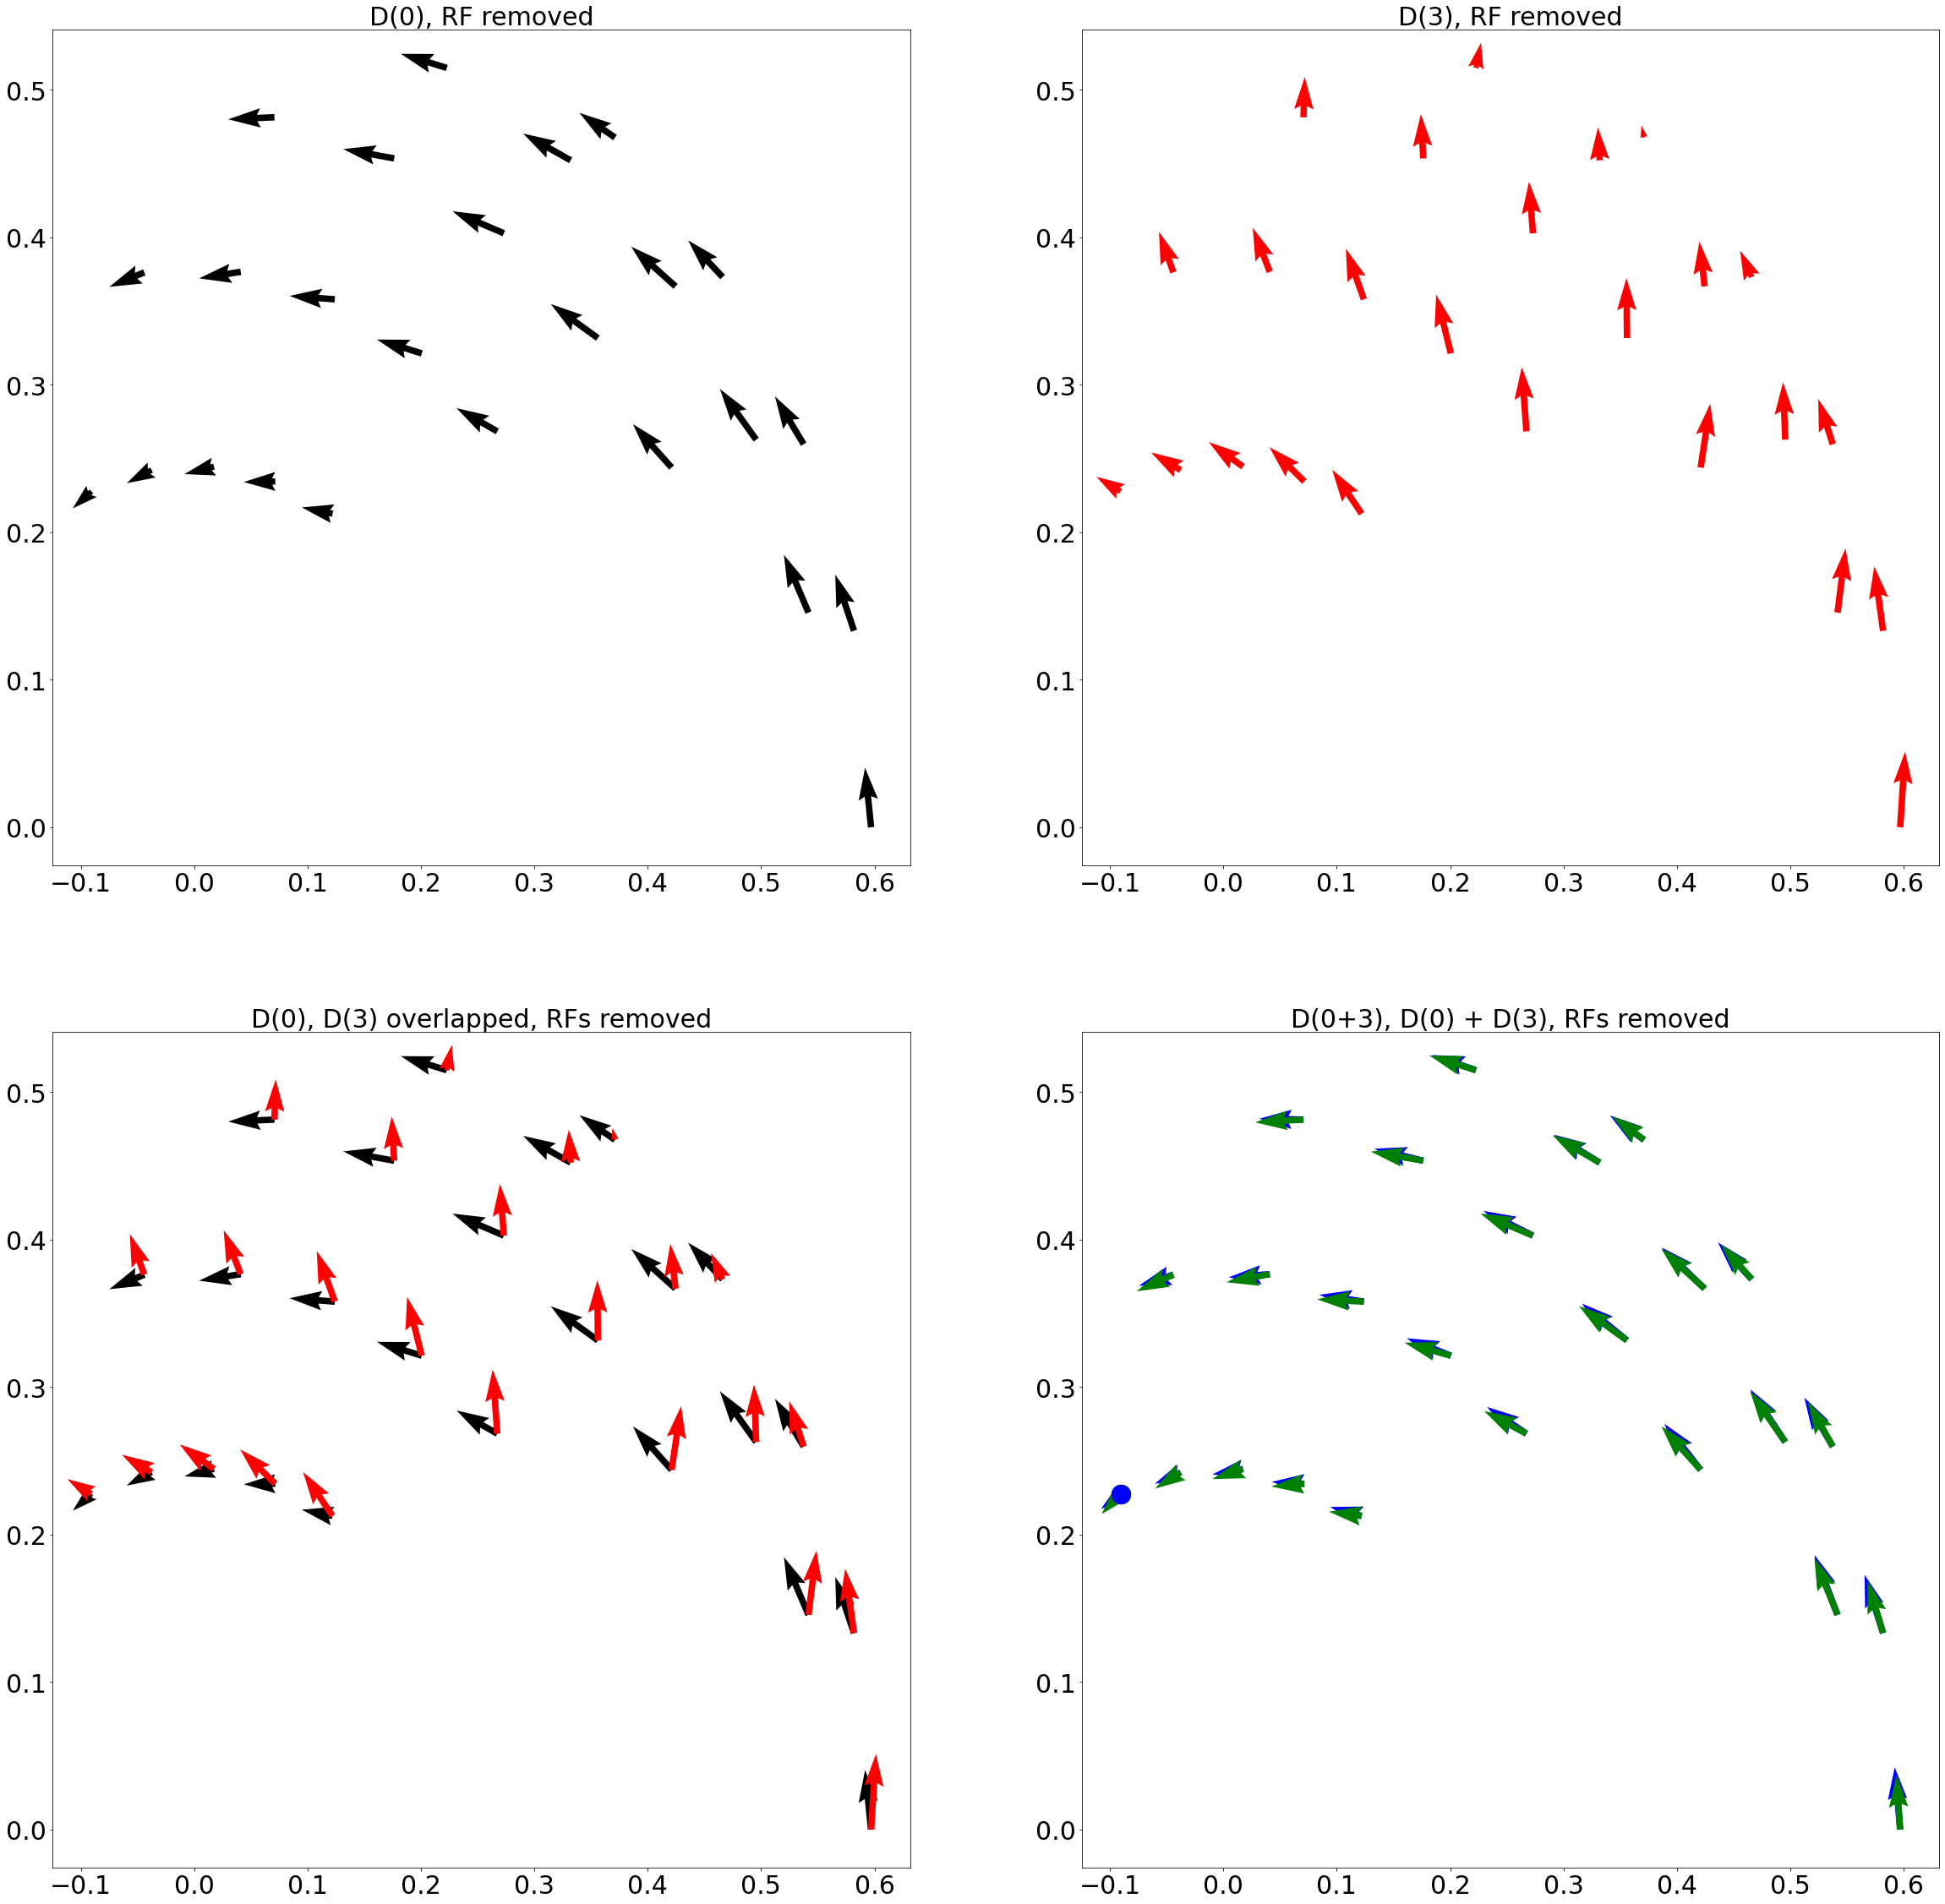

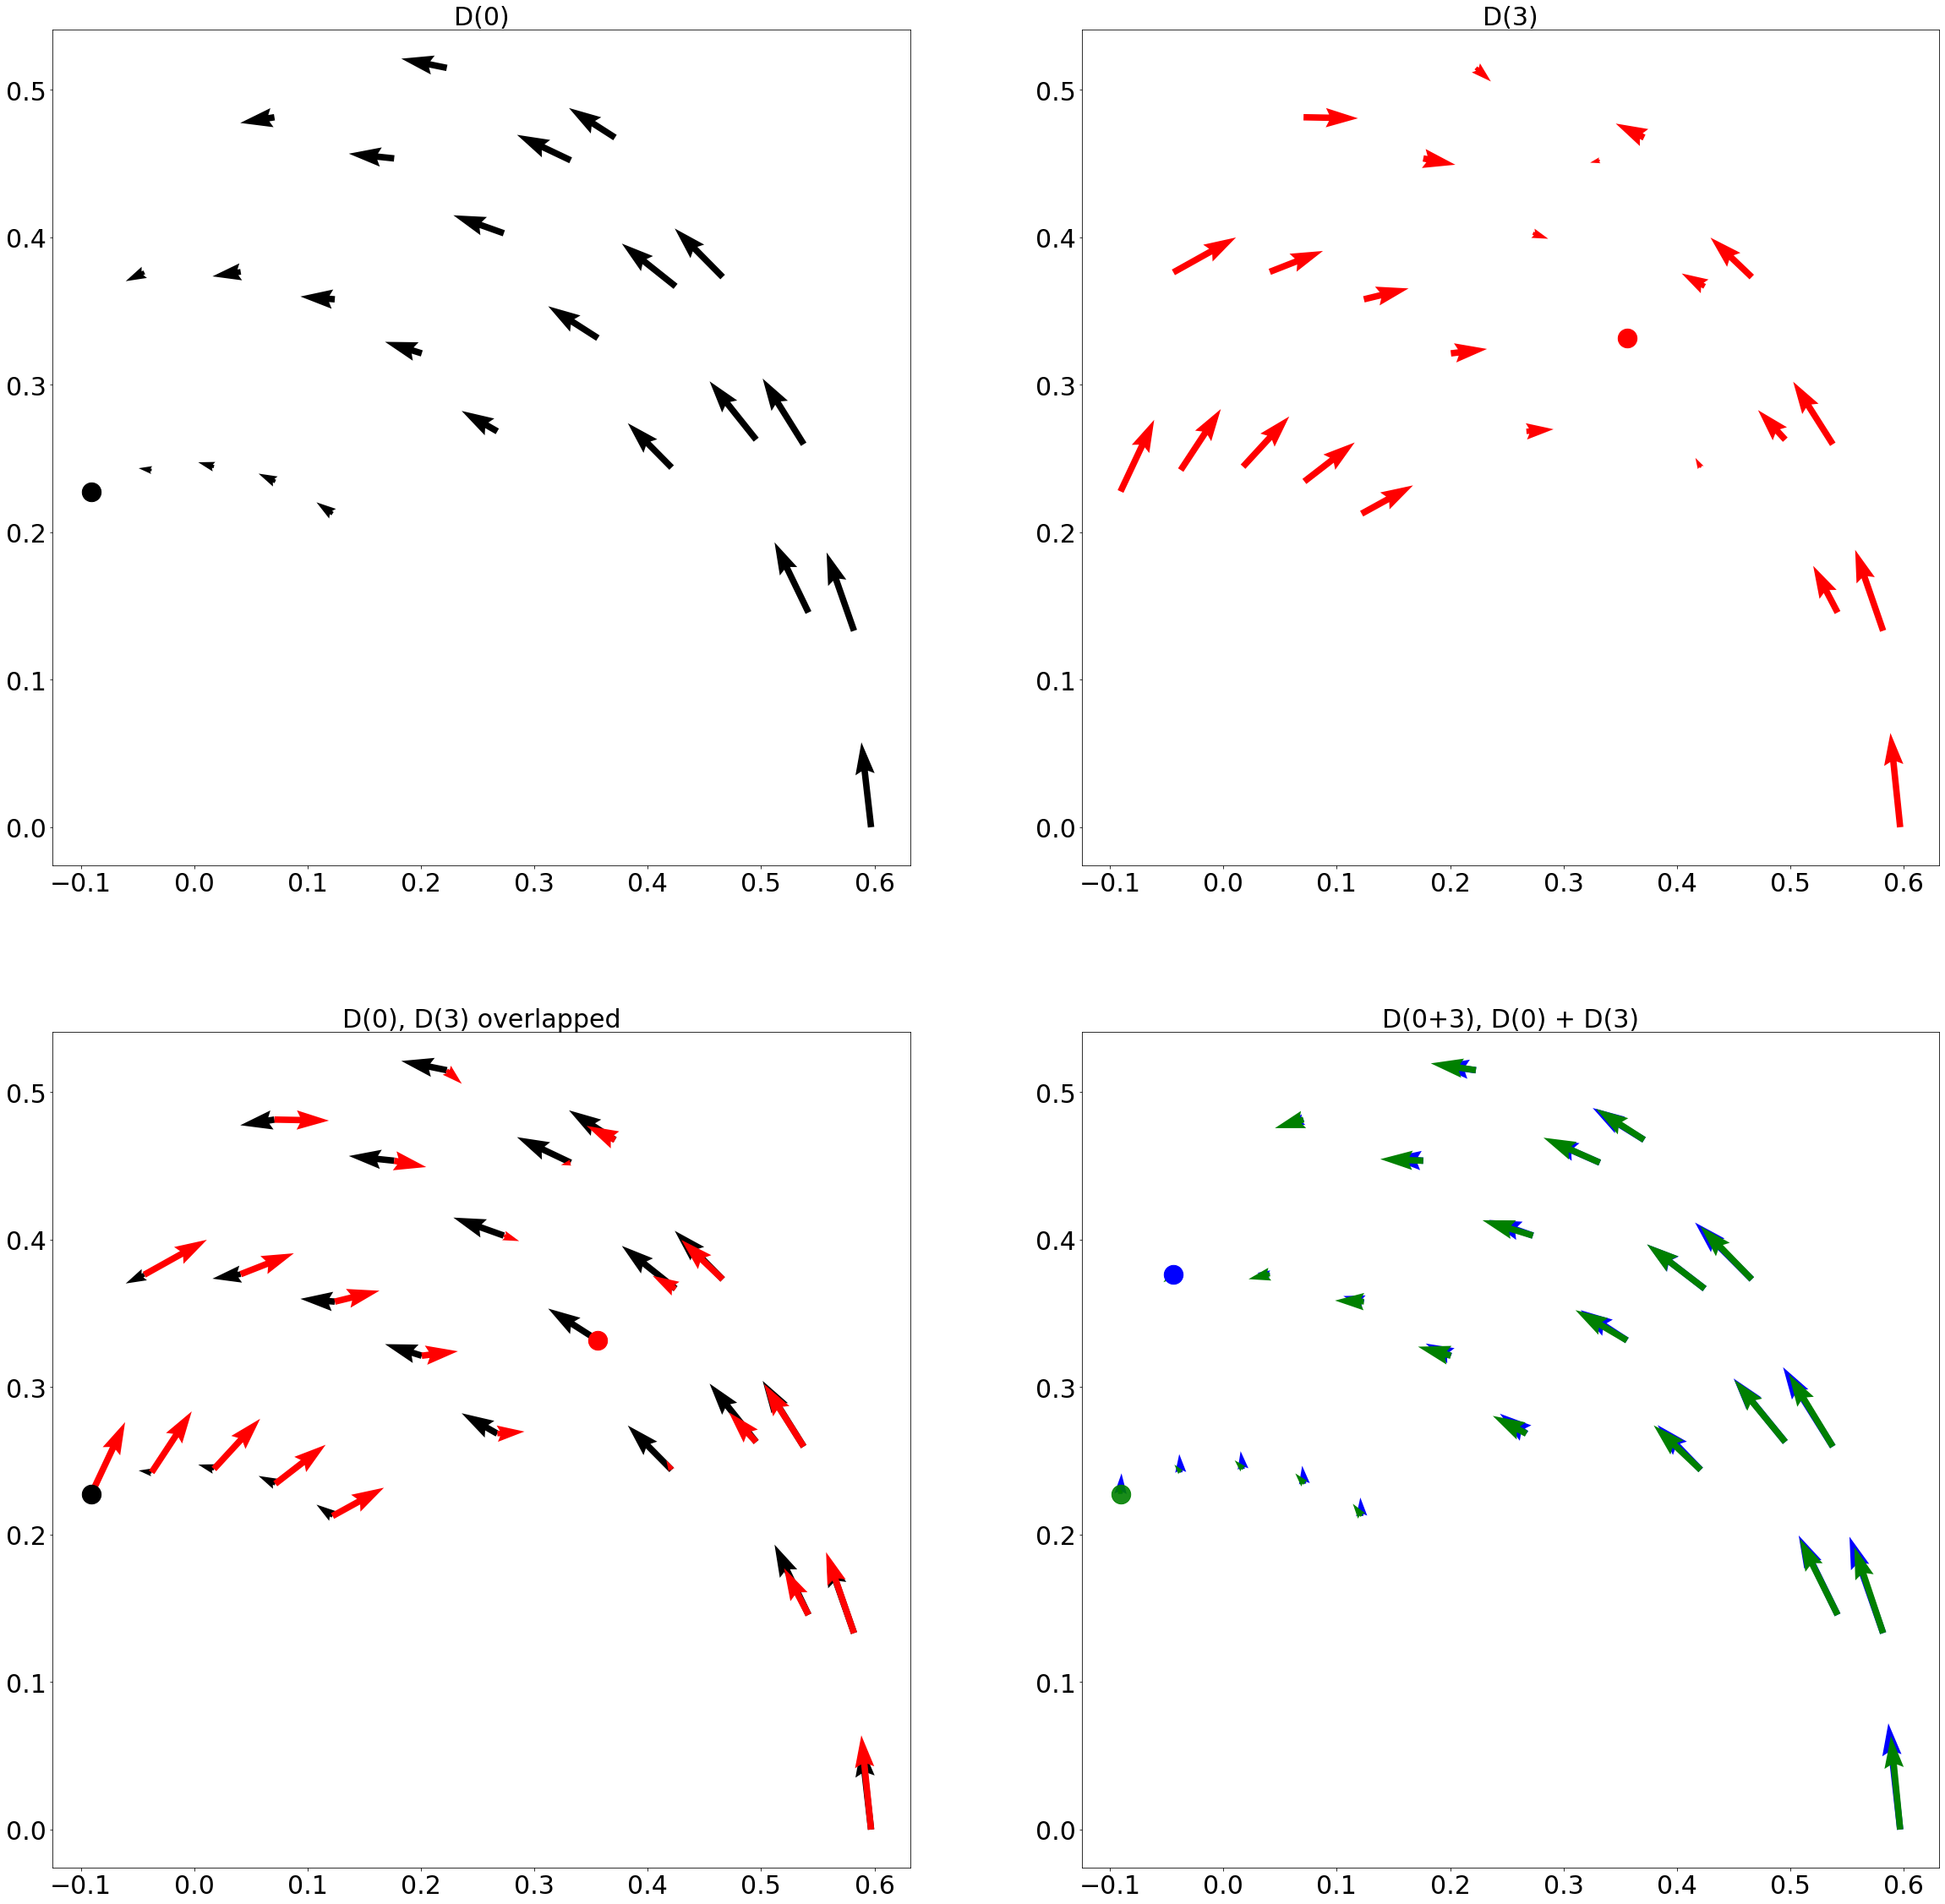

In [37]:
# plot direction fields.
scale = 4. # factor to scale the direction vectors (when using arrow)
m1 = 0 # first zone to stimulate
m2 = 3 # second zone to stimulate
quiver = True # use quiver to plot (otherwise arrow is used)
tit_s = 30 # title font size
tic_s = 30 # tick size
lab_s = 25 # label size

if m1 > m2: # make sure m1 is the smallest
    m = m2;    m2 = m1;    m1 = m
elif m1 == m2:
    raise ValueError('m1 == m2')
p_idx = 0
while p_idx < 15:
    if m1 == double_stim[p_idx][0] and m2 == double_stim[p_idx][1]:
        break
    else:
        p_idx += 1

dirs0 = scale * (all_fhc[0] - all_hc[0])
    
#---------------------------------------------------------------------------------------------------------
#--------------------------- Resting field removed -------------------------------------------------------
#---------------------------------------------------------------------------------------------------------
dirs1 = scale * (all_fhc[1+m1] - all_hc[1+m1]) - dirs0
dirs2 = scale * (all_fhc[1+m2] - all_hc[1+m2]) - dirs0
dirs3 = scale * (all_fhc[7+p_idx] - all_hc[7+p_idx]) - dirs0
dirs4 = dirs1 + dirs2

# obtaining the coordinate with the least change for each field
min_coord0 = all_hc[0][np.argmin(np.linalg.norm(dirs0, axis=1))]
min_coord1 = all_hc[1+m1][np.argmin(np.linalg.norm(dirs1, axis=1))]
min_coord2 = all_hc[1+m2][np.argmin(np.linalg.norm(dirs2, axis=1))]
min_coord3 = all_hc[7+p_idx][np.argmin(np.linalg.norm(dirs3, axis=1))]
min_coord4 = all_hc[7+p_idx][np.argmin(np.linalg.norm(dirs4, axis=1))]

dir_fig, dir_axes = plt.subplots(2,2,figsize=(40,40)) #, sharex=True, sharey=True)
if quiver:
    q1 = dir_axes[0,0].quiver(all_hc[1+m1][:,0], all_hc[1+m1][:,1], dirs1[:,0], dirs1[:,1], color='black')
    q2 = dir_axes[0,1].quiver(all_hc[1+m2][:,0], all_hc[1+m2][:,1], dirs2[:,0], dirs2[:,1], color='red')
    q3 = dir_axes[1,0].quiver(all_hc[1+m1][:,0], all_hc[1+m1][:,1], dirs1[:,0], dirs1[:,1], color='black')
    q3 = dir_axes[1,0].quiver(all_hc[1+m2][:,0], all_hc[1+m2][:,1], dirs2[:,0], dirs2[:,1], color='red')
    q4 = dir_axes[1,1].quiver(all_hc[7+p_idx][:,0], all_hc[7+p_idx][:,1], dirs4[:,0], dirs4[:,1], color='blue')
    q4 = dir_axes[1,1].quiver(all_hc[7+p_idx][:,0], all_hc[7+p_idx][:,1], dirs3[:,0], dirs3[:,1], color='green')
else:
    for coords, dirs in zip(all_hc[1+m1], dirs1):
        dir_axes[0,0].arrow(coords[0], coords[1], dirs[0], dirs[1], color='black')
    for coords, dirs in zip(all_hc[1+m2], dirs2):
        dir_axes[0,1].arrow(coords[0], coords[1], dirs[0], dirs[1], color='red')
    for coords, dirs in zip(all_hc[1+m1], dirs1):
        dir_axes[1,0].arrow(coords[0], coords[1], dirs[0], dirs[1], color='black')
    for coords, dirs in zip(all_hc[1+m2], dirs2):
        dir_axes[1,0].arrow(coords[0], coords[1], dirs[0], dirs[1], color='red')
    for coords, dirs in zip(all_hc[7+p_idx], dirs3):
        dir_axes[1,1].arrow(coords[0], coords[1], dirs[0], dirs[1], color='blue')
    for coords, dirs in zip(all_hc[7+p_idx], dirs4):
        dir_axes[1,1].arrow(coords[0], coords[1], dirs[0], dirs[1], color='green')
        
#scat1 = dir_axes[0,0].scatter(min_coord1[0], min_coord1[1],  s=500, c='black')
dir_axes[0,0].set_title("D("+ str(m1) +"), RF removed", fontsize=tit_s)
dir_axes[0,0].tick_params(axis='both', labelsize=tic_s)
#scat2 = dir_axes[0,1].scatter(min_coord2[0], min_coord2[1],  s=500, c='red')
dir_axes[0,1].set_title("D("+ str(m2) +"), RF removed", fontsize=tit_s)
dir_axes[0,1].tick_params(axis='both', labelsize=tic_s)
#scat3 = dir_axes[1,0].scatter(min_coord1[0], min_coord1[1],  s=500, c='black')
#scat3 = dir_axes[1,0].scatter(min_coord2[0], min_coord2[1],  s=500, c='red')
dir_axes[1,0].set_title("D("+ str(m1) +"), D("+ str(m2) +") overlapped, RFs removed", fontsize=tit_s)
dir_axes[1,0].tick_params(axis='both', labelsize=tic_s)
scat4 = dir_axes[1,1].scatter(min_coord3[0], min_coord3[1],  s=500, c='green', alpha=0.9)
scat4 = dir_axes[1,1].scatter(min_coord4[0], min_coord4[1],  s=500, c='blue')
dir_axes[1,1].set_title("D("+ str(m1) +"+"+str(m2) + "), D("+ str(m1) +") + D("+ str(m2) +"), RFs removed", fontsize=tit_s)
dir_axes[1,1].tick_params(axis='both', labelsize=tic_s)
    
for ax in dir_axes.flatten():
    ax.tick_params(axis='both', labelsize=tic_s)
    
# obtain a similarity measure of fields 3 and 4 (average angle)
# 1) normalize the direction vectors
norm_dirs3 = np.zeros_like(dirs3)
for idx, vec in enumerate(dirs3):
    norm_dirs3[idx, :] = vec / np.linalg.norm(vec)
norm_dirs4 = np.zeros_like(dirs4)
for idx, vec in enumerate(dirs4):
    norm_dirs4[idx, :] = vec / np.linalg.norm(vec)
# 2) Obtain the dot products between normalized vectors
dps = np.sum(norm_dirs3*norm_dirs4, axis=1)
# 3) Obtain the average angle
angs = np.arccos(dps)
avg_ang = angs.sum()/angs.size
print("Resting field removed:")
print("Average angle: %f radians, %f degrees" % (avg_ang, 180.*avg_ang/np.pi))

#---------------------------------------------------------------------------------------------------------
#----------------------- Resting field not removed -------------------------------------------------------
#---------------------------------------------------------------------------------------------------------

dirs1 = scale * (all_fhc[1+m1] - all_hc[1+m1])
dirs2 = scale * (all_fhc[1+m2] - all_hc[1+m2])
dirs3 = scale * (all_fhc[7+p_idx] - all_hc[7+p_idx])
dirs4 = dirs1 + dirs2

# obtaining the coordinate with the least change for each field
min_coord0 = all_hc[0][np.argmin(np.linalg.norm(dirs0, axis=1))]
min_coord1 = all_hc[1+m1][np.argmin(np.linalg.norm(dirs1, axis=1))]
min_coord2 = all_hc[1+m2][np.argmin(np.linalg.norm(dirs2, axis=1))]
min_coord3 = all_hc[7+p_idx][np.argmin(np.linalg.norm(dirs3, axis=1))]
min_coord4 = all_hc[7+p_idx][np.argmin(np.linalg.norm(dirs4, axis=1))]

dir_fig2, dir_axes2 = plt.subplots(2,2,figsize=(40,40)) #, sharex=True, sharey=True)
if quiver:
    q1 = dir_axes2[0,0].quiver(all_hc[1+m1][:,0], all_hc[1+m1][:,1], dirs1[:,0], dirs1[:,1], color='black')
    q2 = dir_axes2[0,1].quiver(all_hc[1+m2][:,0], all_hc[1+m2][:,1], dirs2[:,0], dirs2[:,1], color='red')
    q3 = dir_axes2[1,0].quiver(all_hc[1+m1][:,0], all_hc[1+m1][:,1], dirs1[:,0], dirs1[:,1], color='black')
    q3 = dir_axes2[1,0].quiver(all_hc[1+m2][:,0], all_hc[1+m2][:,1], dirs2[:,0], dirs2[:,1], color='red')
    q4 = dir_axes2[1,1].quiver(all_hc[7+p_idx][:,0], all_hc[7+p_idx][:,1], dirs4[:,0], dirs4[:,1], color='blue')
    q4 = dir_axes2[1,1].quiver(all_hc[7+p_idx][:,0], all_hc[7+p_idx][:,1], dirs3[:,0], dirs3[:,1], color='green')
else:
    for coords, dirs in zip(all_hc[1+m1], dirs1):
        dir_axes2[0,0].arrow(coords[0], coords[1], dirs[0], dirs[1], color='black')
    for coords, dirs in zip(all_hc[1+m2], dirs2):
        dir_axes2[0,1].arrow(coords[0], coords[1], dirs[0], dirs[1], color='red')
    for coords, dirs in zip(all_hc[1+m1], dirs1):
        dir_axes2[1,0].arrow(coords[0], coords[1], dirs[0], dirs[1], color='black')
    for coords, dirs in zip(all_hc[1+m2], dirs2):
        dir_axes2[1,0].arrow(coords[0], coords[1], dirs[0], dirs[1], color='red')
    for coords, dirs in zip(all_hc[7+p_idx], dirs3):
        dir_axes2[1,1].arrow(coords[0], coords[1], dirs[0], dirs[1], color='blue')
    for coords, dirs in zip(all_hc[7+p_idx], dirs4):
        dir_axes2[1,1].arrow(coords[0], coords[1], dirs[0], dirs[1], color='green')
        
scat1 = dir_axes2[0,0].scatter(min_coord1[0], min_coord1[1],  s=500, c='black')
dir_axes2[0,0].set_title("D("+ str(m1) +")", fontsize=tit_s)
dir_axes2[0,0].tick_params(axis='both', labelsize=tic_s)
scat2 = dir_axes2[0,1].scatter(min_coord2[0], min_coord2[1],  s=500, c='red')
dir_axes2[0,1].set_title("D("+ str(m2) +")", fontsize=tit_s)
dir_axes2[0,1].tick_params(axis='both', labelsize=tic_s)
scat3 = dir_axes2[1,0].scatter(min_coord1[0], min_coord1[1],  s=500, c='black')
scat3 = dir_axes2[1,0].scatter(min_coord2[0], min_coord2[1],  s=500, c='red')
dir_axes2[1,0].set_title("D("+ str(m1) +"), D("+ str(m2) +") overlapped", fontsize=tit_s)
dir_axes2[1,0].tick_params(axis='both', labelsize=tic_s)
scat4 = dir_axes2[1,1].scatter(min_coord3[0], min_coord3[1],  s=500, c='green', alpha=0.9)
scat4 = dir_axes2[1,1].scatter(min_coord4[0], min_coord4[1],  s=500, c='blue')
dir_axes2[1,1].set_title("D("+ str(m1) +"+"+str(m2) + "), D("+ str(m1) +") + D("+ str(m2) +")", fontsize=tit_s)
dir_axes2[1,1].tick_params(axis='both', labelsize=tic_s)

# obtain a similarity measure of fields 3 and 4 (average angle)
# 1) normalize the direction vectors
norm_dirs3 = np.zeros_like(dirs3)
for idx, vec in enumerate(dirs3):
    norm_dirs3[idx, :] = vec / np.linalg.norm(vec)
norm_dirs4 = np.zeros_like(dirs4)
for idx, vec in enumerate(dirs4):
    norm_dirs4[idx, :] = vec / np.linalg.norm(vec)
# 2) Obtain the dot products between normalized vectors
dps = np.sum(norm_dirs3*norm_dirs4, axis=1)
# 3) Obtain the average angle
angs = np.arccos(dps)
avg_ang = angs.sum()/angs.size
print("\n Resting field not removed:")
print("Average angle: %f radians, %f degrees" % (avg_ang, 180.*avg_ang/np.pi))

# Plot resting field
# dir0_fig = plt.figure(figsize=(15,15))
# ax = plt.gca()
# if quiver:
#     q0 = ax.quiver(all_hc[0][:,0], all_hc[0][:,1], dirs0[:,0], dirs0[:,1], color='blue')
# else:
#     for coords, dirs in zip(all_hc[0], dirs0):
#         ax.arrow(coords[0], coords[1], dirs[0], dirs[1], color='blue')
# scat0 = ax.scatter(min_coord0[0], min_coord0[1],  s=500, c='blue')
# ax.scatter(targets[:,0], targets[:,1], s=1800, c='cyan')
# ax.plot([center[0]], [center[1]], 'g+', linewidth=5)
# ax.scatter([center[0]], [center[1]], s=2000, c='green')
# plt.title("Resting Field", fontsize=tit_s)
# plt.xticks(fontsize=tic_s)
# plt.yticks(fontsize=tic_s)
# ax.set_xlim([0.15,.45])
# ax.set_ylim([0.15,.45])
# ax.set_xlabel('X [m]', fontsize=lab_s)
# ax.set_ylabel('Y [m]', fontsize=lab_s)

plt.show()

---

---

In [38]:
# run simulations for one set of combinations
start_wctime = time.time()
sim_time = 2. # 1. simulation time
E_amp = 5. # amplitude of stimulus to CE population
I_amp = 2. # amplitude of stimulus to CI population
n_procs = 30 # number of processes to use for grid simulation
# no C units are stimulated (resting field)
hand_coords0, final_hand_coords0, t0, ad0, apd0 = get_dir_field_par([], sim_time, SYNE_w=E_amp, 
                                        SYNI_w=I_amp, s_subs=s_subs, e_subs=e_subs, n_procs=n_procs)
# A couple of flexor units stimulated
hand_coords1, final_hand_coords1, t1, ad1, apd1 = get_dir_field_par([0], sim_time, SYNE_w=E_amp,
                                        SYNI_w=I_amp, s_subs=s_subs, e_subs=e_subs, n_procs=n_procs)
# A couple of extensor units stimulated
#hand_coords2, final_hand_coords2, t2, ad2, apd2 = get_dir_field_par([0,1], sim_time, SYNE_w=E_amp, SYNI_w=I_amp, n_procs=n_procs)
hand_coords2, final_hand_coords2, t2, ad2, apd2 = get_dir_field_par([3], sim_time, SYNE_w=E_amp,
                                        SYNI_w=I_amp, s_subs=s_subs, e_subs=e_subs, n_procs=n_procs) # alternative stimulus
# Both flexor and extensor units stimulated
#hand_coords3, final_hand_coords3, t3, ad3, apd3 = get_dir_field_par([0, 1, 2, 3], sim_time, SYNE_w=E_amp, SYNI_w=I_amp, n_procs=n_procs)
hand_coords3, final_hand_coords3, t3, ad3, apd3 = get_dir_field_par([0, 3], sim_time, SYNE_w=E_amp,
                                        SYNI_w=I_amp, s_subs=s_subs, e_subs=e_subs, n_procs=n_procs) # alternative stimulus
print("done!")
print('\n Execution time is %s seconds' % (time.time() - start_wctime))

done!

 Execution time is 15.661813735961914 seconds


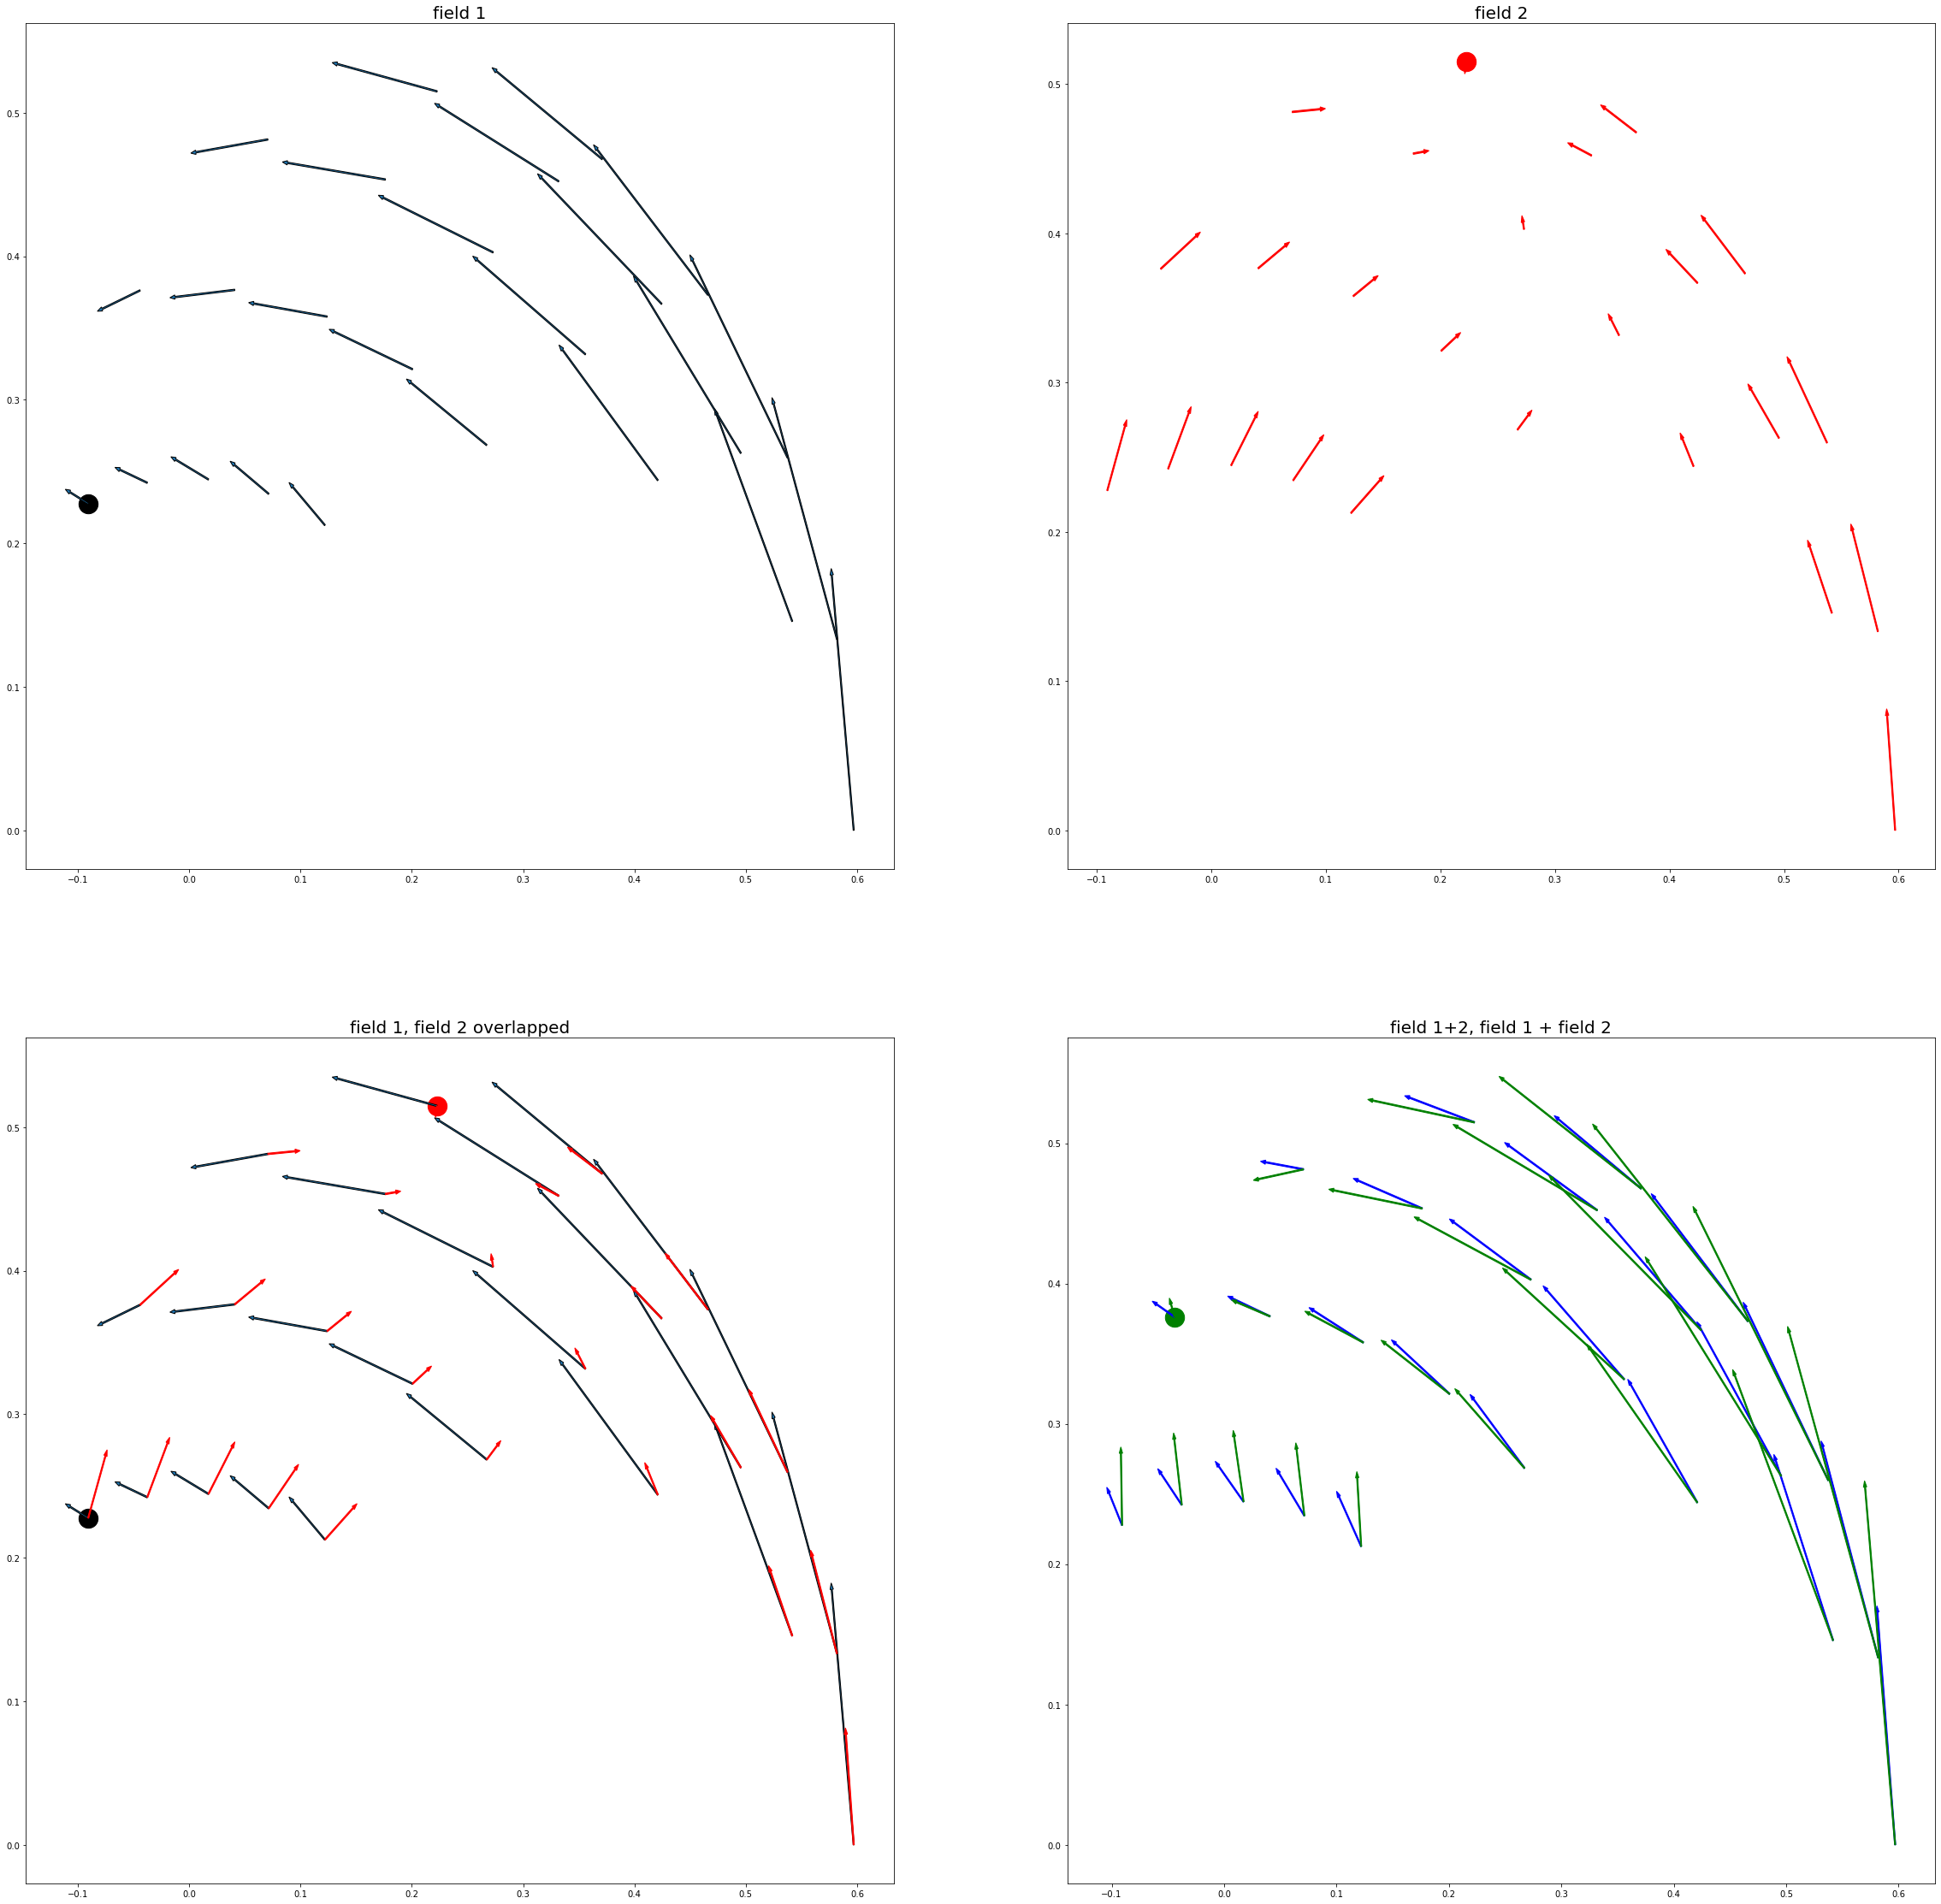

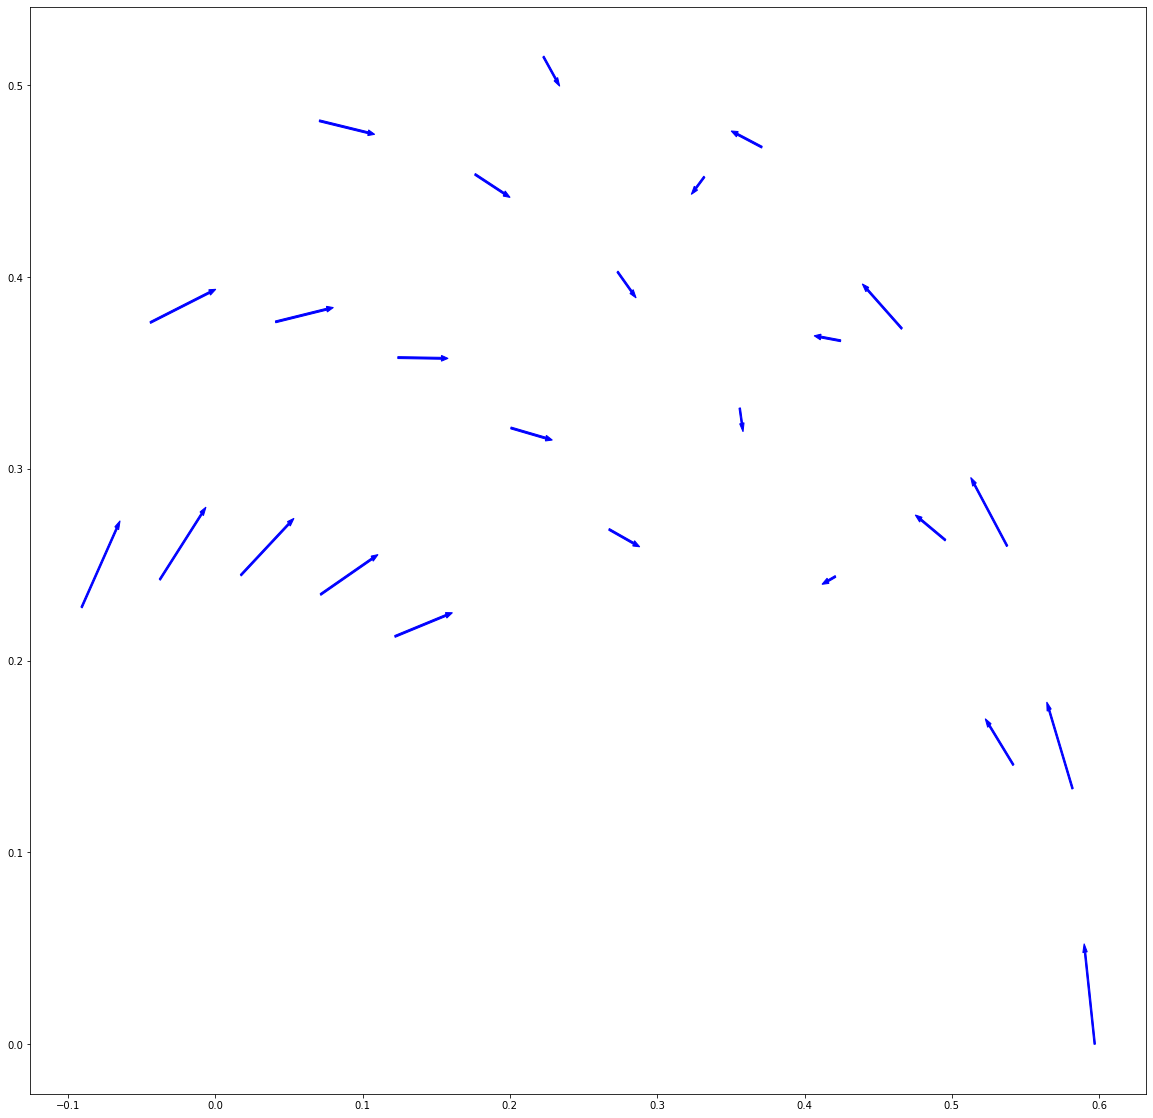

Average angle: 0.191206 radians
Average angle: 10.955278 degrees


In [39]:
# plot direction fields.
scale = 2. # factor to scale the direction vectors
dirs0 = scale * (final_hand_coords0 - hand_coords0)
dirs1 = scale * (final_hand_coords1 - hand_coords1)
dirs2 = scale * (final_hand_coords2 - hand_coords2)
dirs3 = scale * (final_hand_coords3 - hand_coords3)
dirs4 = dirs1 + dirs2

# obtaining the coordinate with the least change for each field
min_coord0 = hand_coords0[np.argmin(np.linalg.norm(dirs0, axis=1))]
min_coord1 = hand_coords0[np.argmin(np.linalg.norm(dirs1, axis=1))]
min_coord2 = hand_coords0[np.argmin(np.linalg.norm(dirs2, axis=1))]
min_coord3 = hand_coords0[np.argmin(np.linalg.norm(dirs3, axis=1))]
min_coord4 = hand_coords0[np.argmin(np.linalg.norm(dirs4, axis=1))]

dir_fig, dir_axes = plt.subplots(2,2,figsize=(40,40))
#q1 = dir_axes[0,0].quiver(hand_coords1[:,0], hand_coords1[:,1], dirs1[:,0], dirs1[:,1])
for coords, dirs in zip(hand_coords1, dirs1):
    dir_axes[0,0].arrow(coords[0], coords[1], dirs[0], dirs[1])
scat1 = dir_axes[0,0].scatter(min_coord1[0], min_coord1[1],  s=500, c='black')
dir_axes[0,0].set_title("field 1", fontsize=20)

#q2 = dir_axes[0,1].quiver(hand_coords2[:,0], hand_coords2[:,1], dirs2[:,0], dirs2[:,1])
for coords, dirs in zip(hand_coords2, dirs2):
    dir_axes[0,1].arrow(coords[0], coords[1], dirs[0], dirs[1], color='red')
scat2 = dir_axes[0,1].scatter(min_coord2[0], min_coord2[1],  s=500, c='red')
dir_axes[0,1].set_title("field 2", fontsize=20)

#q3 = dir_axes[1,0].quiver(hand_coords1[:,0], hand_coords1[:,1], dirs1[:,0], dirs1[:,1])
#q3 = dir_axes[1,0].quiver(hand_coords2[:,0], hand_coords2[:,1], dirs2[:,0], dirs2[:,1], color='red')
for coords, dirs in zip(hand_coords1, dirs1):
    dir_axes[1,0].arrow(coords[0], coords[1], dirs[0], dirs[1])
for coords, dirs in zip(hand_coords2, dirs2):
    dir_axes[1,0].arrow(coords[0], coords[1], dirs[0], dirs[1], color='red')
scat3 = dir_axes[1,0].scatter(min_coord1[0], min_coord1[1],  s=500, c='black')
scat3 = dir_axes[1,0].scatter(min_coord2[0], min_coord2[1],  s=500, c='red')
dir_axes[1,0].set_title("field 1, field 2 overlapped", fontsize=20)

#q4 = dir_axes[1,1].quiver(hand_coords3[:,0], hand_coords3[:,1], dirs4[:,0], dirs4[:,1], color='blue')
for coords, dirs in zip(hand_coords3, dirs3):
    dir_axes[1,1].arrow(coords[0], coords[1], dirs[0], dirs[1], color='blue')
for coords, dirs in zip(hand_coords3, dirs4):
    dir_axes[1,1].arrow(coords[0], coords[1], dirs[0], dirs[1], color='green')
scat4 = dir_axes[1,1].scatter(min_coord4[0], min_coord4[1],  s=500, c='green')
dir_axes[1,1].set_title("field 1+2, field 1 + field 2", fontsize=20)

dir_fig0 = plt.figure(figsize=(20,20))
ax = plt.gca()
for coords, dirs in zip(hand_coords0, dirs0):
    ax.arrow(coords[0], coords[1], dirs[0], dirs[1], color='blue')

plt.show()

# obtain a similarity measure of fields 3 and 4 (average angle)
# 1) normalize the direction vectors
norm_dirs3 = np.zeros_like(dirs3)
for idx, vec in enumerate(dirs3):
    norm_dirs3[idx, :] = vec / np.linalg.norm(vec)
norm_dirs4 = np.zeros_like(dirs4)
for idx, vec in enumerate(dirs4):
    norm_dirs4[idx, :] = vec / np.linalg.norm(vec)
# 2) Obtain the dot products between normalized vectors
dps = np.sum(norm_dirs3*norm_dirs4, axis=1)
# 3) Obtain the average angle
angs = np.arccos(dps)
avg_ang = angs.sum()/angs.size
print("Average angle: %f radians" % (avg_ang))
print("Average angle: %f degrees" % (180.*avg_ang/np.pi))

Average angle: 0.150910 radians
Average angle: 8.646529 degrees


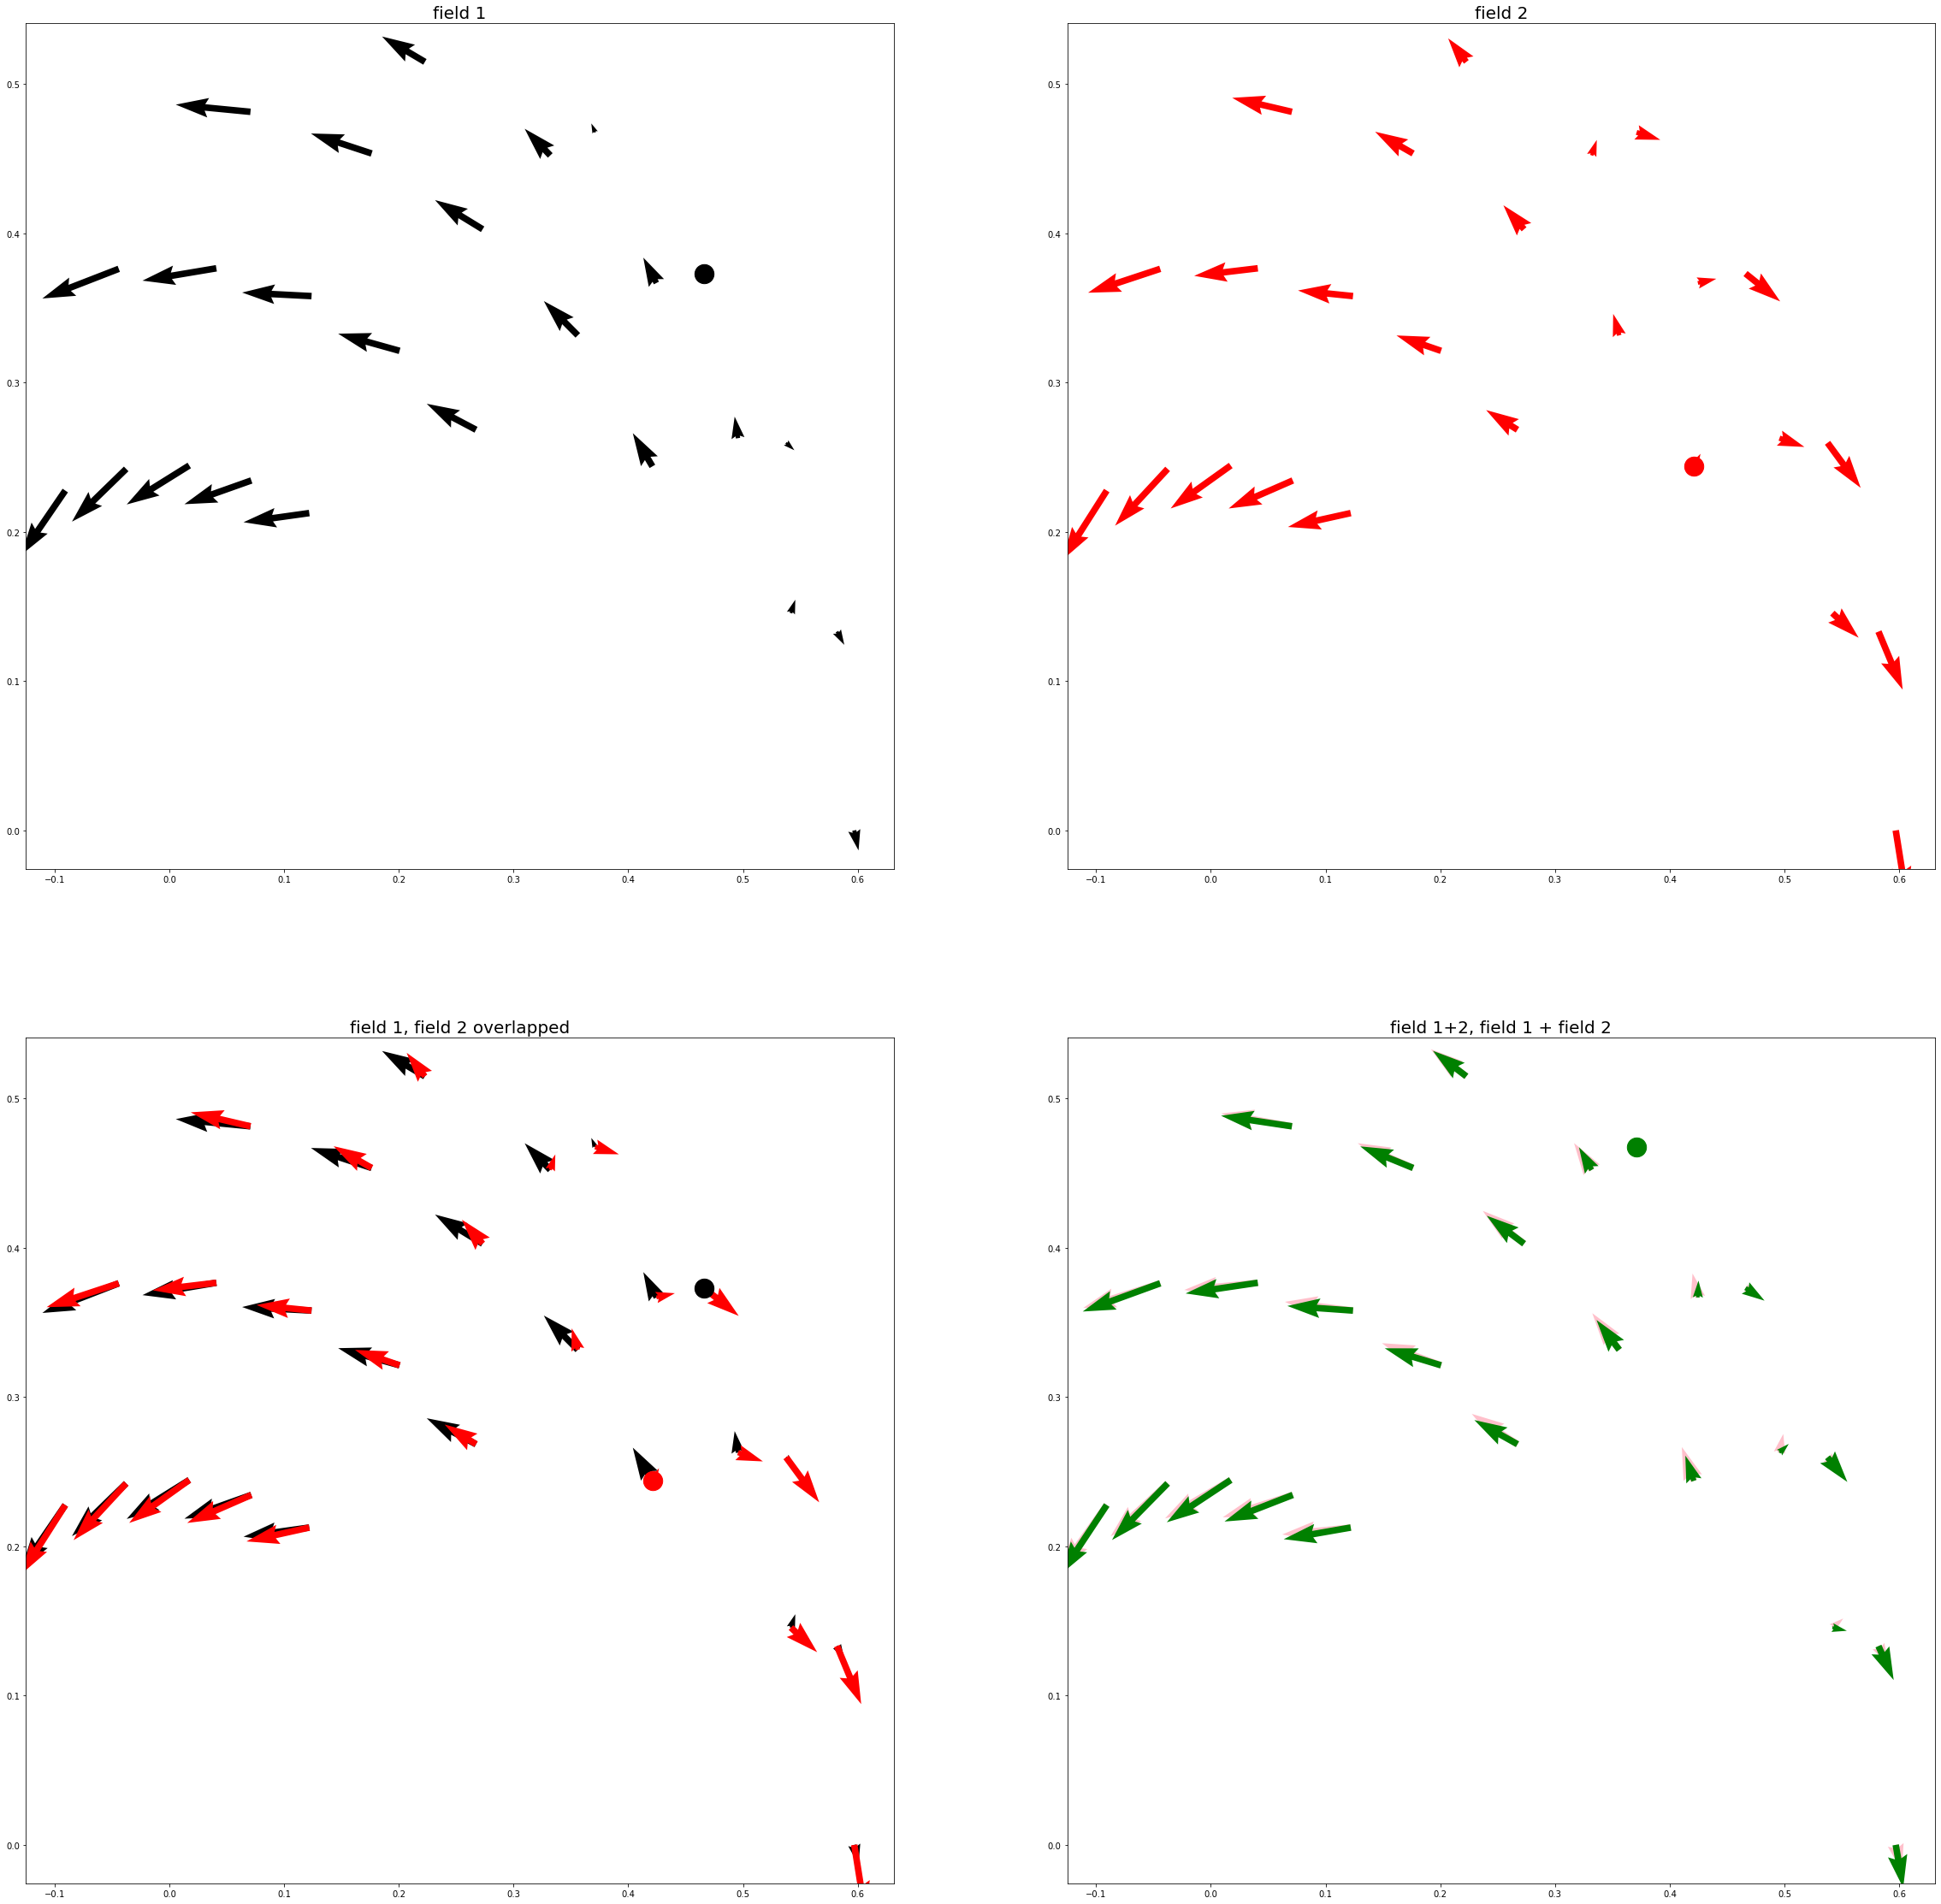

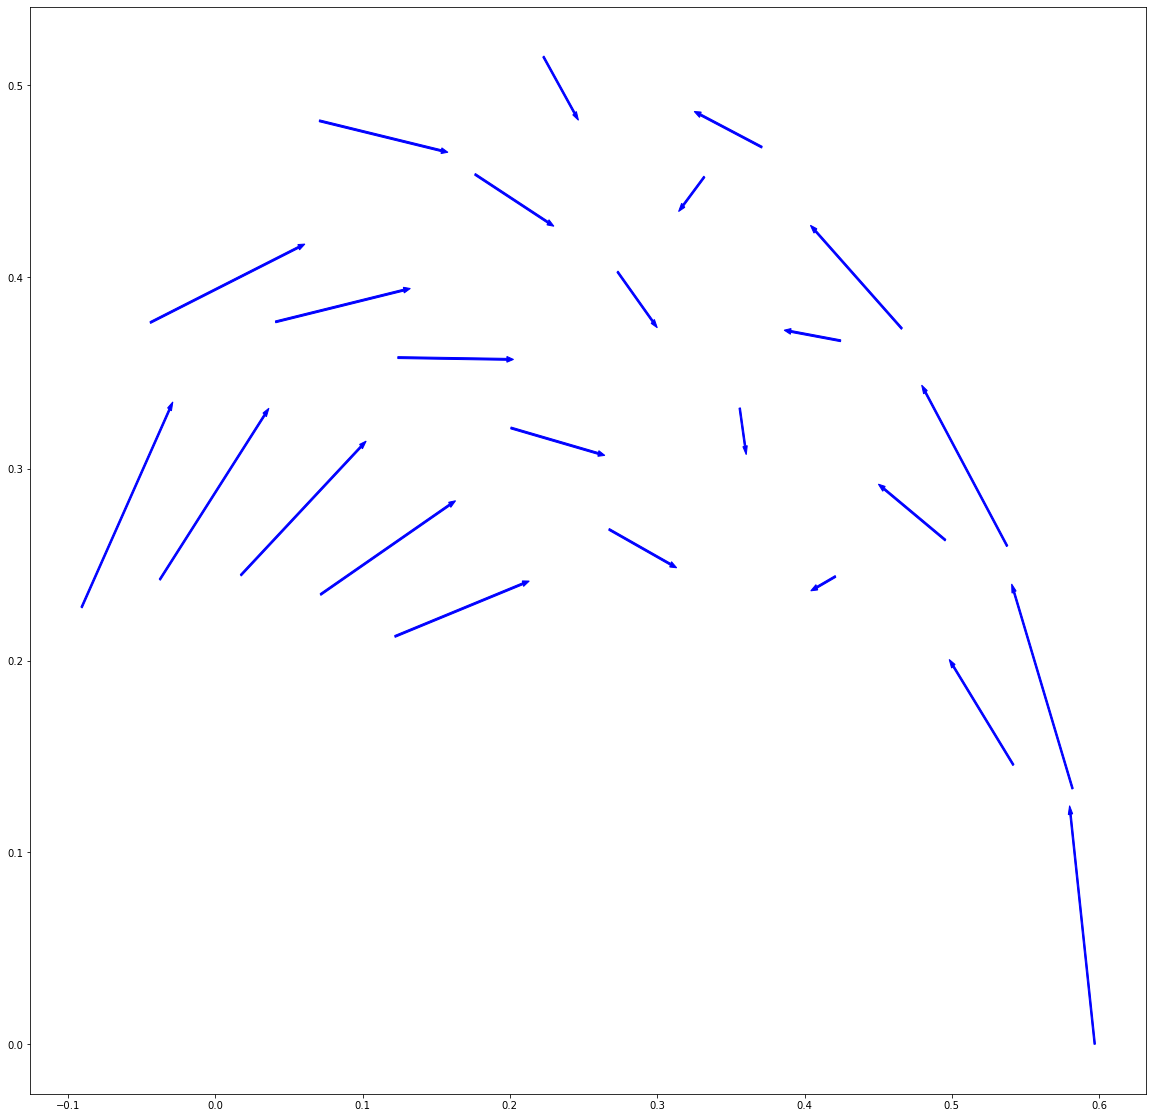

In [40]:
# plot directionsfields. Version with resting field removed.
scale = 5.
dirs0 = scale * (final_hand_coords0 - hand_coords0)
dirs1 = scale * (final_hand_coords1 - hand_coords1 - dirs0)
dirs2 = scale * (final_hand_coords2 - hand_coords2 - dirs0)
dirs3 = scale * (final_hand_coords3 - hand_coords3 - dirs0)
dirs4 = dirs1 + dirs2
# obtaining the coordinate with the least change for each field
min_coord0 = hand_coords0[np.argmin(np.linalg.norm(dirs0, axis=1))]
min_coord1 = hand_coords0[np.argmin(np.linalg.norm(dirs1, axis=1))]
min_coord2 = hand_coords0[np.argmin(np.linalg.norm(dirs2, axis=1))]
min_coord3 = hand_coords0[np.argmin(np.linalg.norm(dirs3, axis=1))]
min_coord4 = hand_coords0[np.argmin(np.linalg.norm(dirs4, axis=1))]

dir_fig, dir_axes = plt.subplots(2,2,figsize=(40,40))
q1 = dir_axes[0,0].quiver(hand_coords1[:,0], hand_coords1[:,1], dirs1[:,0], dirs1[:,1])
# for coords, dirs in zip(hand_coords1, dirs1):
#     dir_axes[0,0].arrow(coords[0], coords[1], dirs[0], dirs[1])
scat1 = dir_axes[0,0].scatter(min_coord1[0], min_coord1[1],  s=500, c='black')
dir_axes[0,0].set_title("field 1", fontsize=20)

q2 = dir_axes[0,1].quiver(hand_coords2[:,0], hand_coords2[:,1], dirs2[:,0], dirs2[:,1], color='red')
# for coords, dirs in zip(hand_coords2, dirs2):
#     dir_axes[0,1].arrow(coords[0], coords[1], dirs[0], dirs[1], color='red')
scat2 = dir_axes[0,1].scatter(min_coord2[0], min_coord2[1],  s=500, c='red')
dir_axes[0,1].set_title("field 2", fontsize=20)

q3 = dir_axes[1,0].quiver(hand_coords1[:,0], hand_coords1[:,1], dirs1[:,0], dirs1[:,1], color='black')
q3 = dir_axes[1,0].quiver(hand_coords2[:,0], hand_coords2[:,1], dirs2[:,0], dirs2[:,1], color='red')
# for coords, dirs in zip(hand_coords1, dirs1):
#     dir_axes[1,0].arrow(coords[0], coords[1], dirs[0], dirs[1])
# for coords, dirs in zip(hand_coords2, dirs2):
#     dir_axes[1,0].arrow(coords[0], coords[1], dirs[0], dirs[1], color='red')
scat3 = dir_axes[1,0].scatter(min_coord1[0], min_coord1[1],  s=500, c='black')
scat3 = dir_axes[1,0].scatter(min_coord2[0], min_coord2[1],  s=500, c='red')
dir_axes[1,0].set_title("field 1, field 2 overlapped", fontsize=20)

q4 = dir_axes[1,1].quiver(hand_coords3[:,0], hand_coords3[:,1], dirs3[:,0], dirs3[:,1], color='pink')
q4 = dir_axes[1,1].quiver(hand_coords3[:,0], hand_coords3[:,1], dirs4[:,0], dirs4[:,1], color='green')
# for coords, dirs in zip(hand_coords3, dirs3):
#     dir_axes[1,1].arrow(coords[0], coords[1], dirs[0], dirs[1], color='pink')
# for coords, dirs in zip(hand_coords3, dirs4):
#     dir_axes[1,1].arrow(coords[0], coords[1], dirs[0], dirs[1], color='green')
scat4 = dir_axes[1,1].scatter(min_coord4[0], min_coord4[1],  s=500, c='green')
#scat4 = dir_axes[1,1].scatter(min_coord4[0], min_coord4[1],  s=500, c='green')
dir_axes[1,1].set_title("field 1+2, field 1 + field 2", fontsize=20)

dir_fig0 = plt.figure(figsize=(20,20))
ax = plt.gca()
for coords, dirs in zip(hand_coords0, dirs0):
    ax.arrow(coords[0], coords[1], dirs[0], dirs[1], color='blue')

# obtain a similarity measure of fields 3 and 4 (average angle)
# 1) normalize the direction vectors
norm_dirs3 = np.zeros_like(dirs3)
for idx, vec in enumerate(dirs3):
    norm_dirs3[idx, :] = vec / np.linalg.norm(vec)
norm_dirs4 = np.zeros_like(dirs4)
for idx, vec in enumerate(dirs4):
    norm_dirs4[idx, :] = vec / np.linalg.norm(vec)
# 2) Obtain the dot products between normalized vectors
dps = np.sum(norm_dirs3*norm_dirs4, axis=1)
# 3) Obtain the average angle
angs = np.arccos(dps)
avg_ang = angs.sum()/angs.size
print("Average angle: %f radians" % (avg_ang))
print("Average angle: %f degrees" % (180.*avg_ang/np.pi))

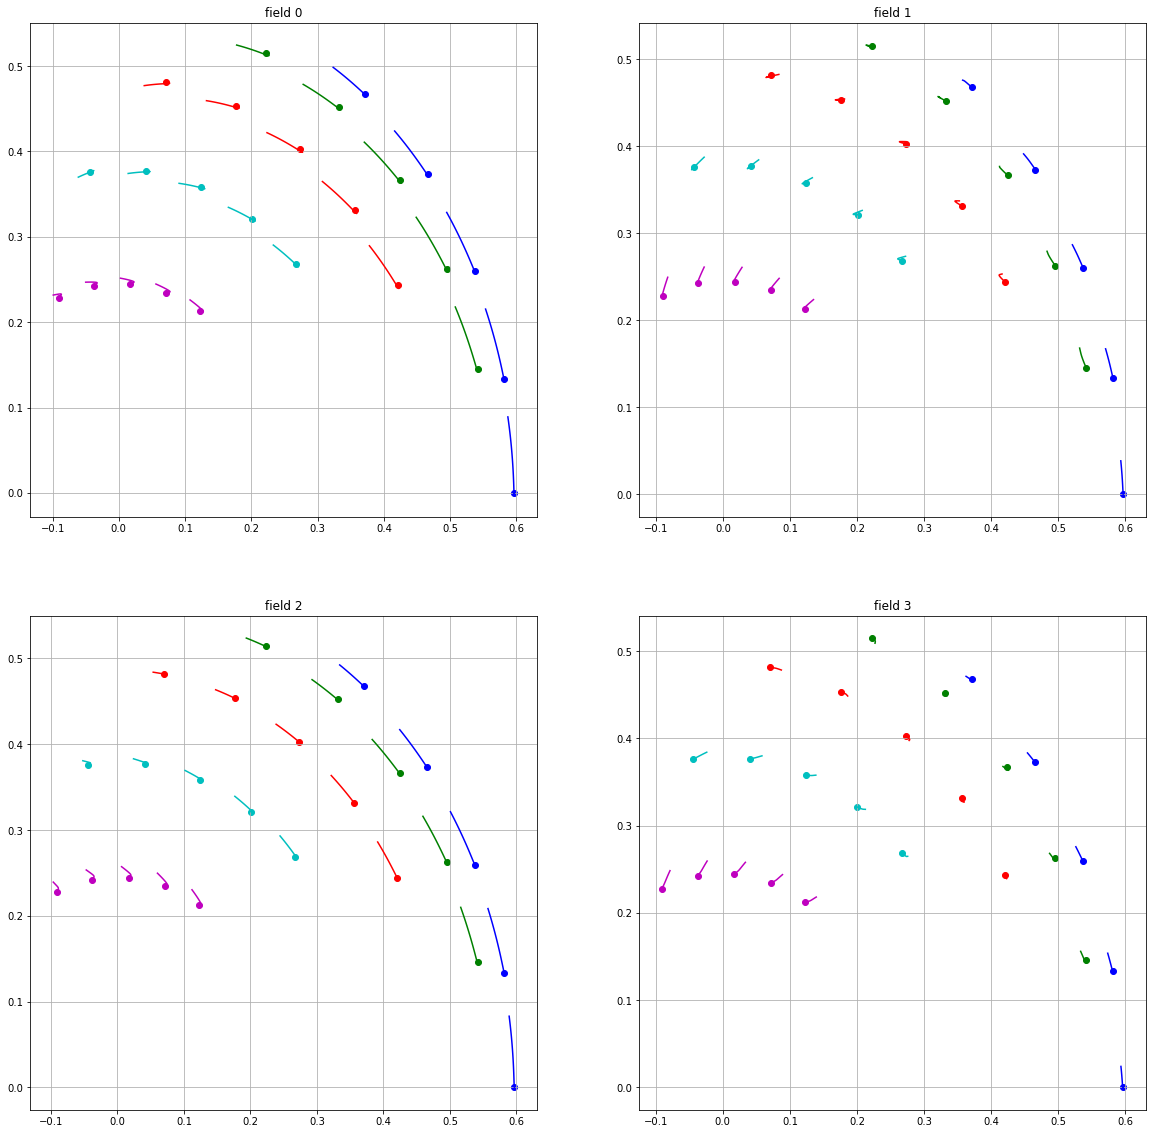

In [41]:
# plot trajectories

net, pops_dict = create_net([0.3,0.3])
for name in list(pops_dict.keys()):
    exec("%s = %s"% (name, str(pops_dict[name])))

l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
apd = [apd1, apd2, apd3, apd0] # the resting field (apd0) is at the end
#apd = [apd0]
# Multiple plots
#----------------
traj_fig, traj_axes = plt.subplots(2,2,figsize=(20,20))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for idx, all_plant_data in enumerate(apd):
    for pd_id, plant_data in enumerate(all_plant_data):
        # angles of shoulder and elbow
        theta_s = plant_data[:,0]
        theta_e = plant_data[:,2]
        phi = theta_s + theta_e # elbow angle wrt x axis
        # coordinates of hand and elbow    
        xe = np.cos(theta_s)*l1
        ye = np.sin(theta_s)*l1
        xh = xe + np.cos(phi)*l2
        yh = ye + np.sin(phi)*l2
        traj_axes[int(idx/2),idx%2].plot(xh,yh, color=colors[pd_id%5])
        traj_axes[int(idx/2),idx%2].grid()
        traj_axes[int(idx/2),idx%2].scatter(xh[0],yh[0], color=colors[pd_id%5])
    traj_axes[int(idx/2),idx%2].set_title("field " + str(idx))

plt.show()

(array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

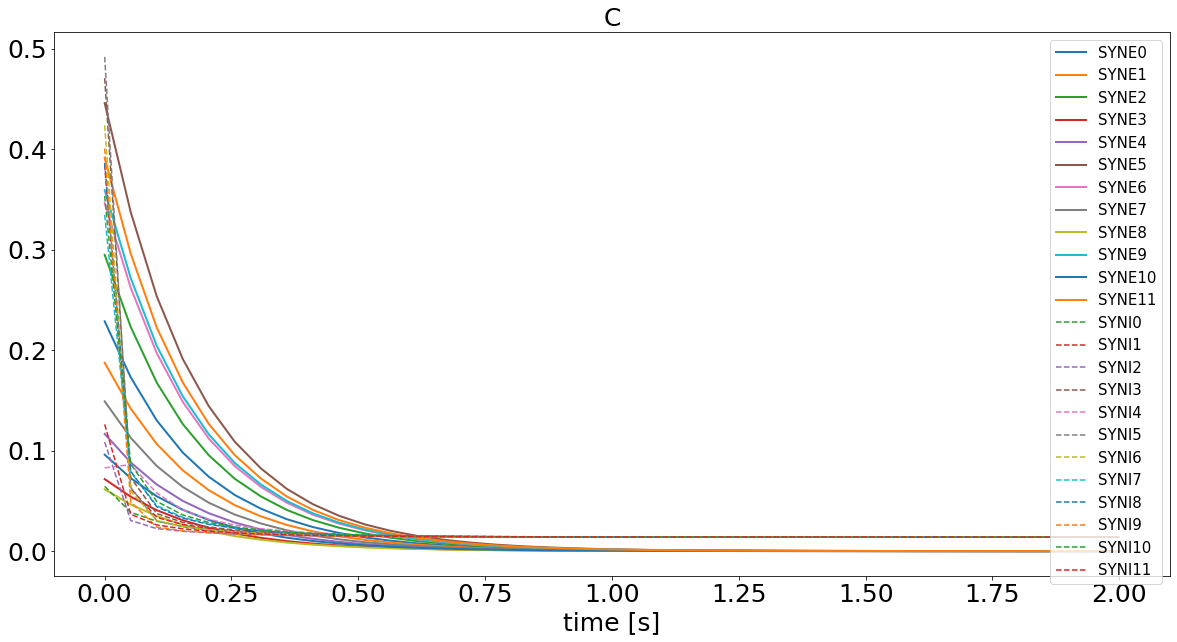

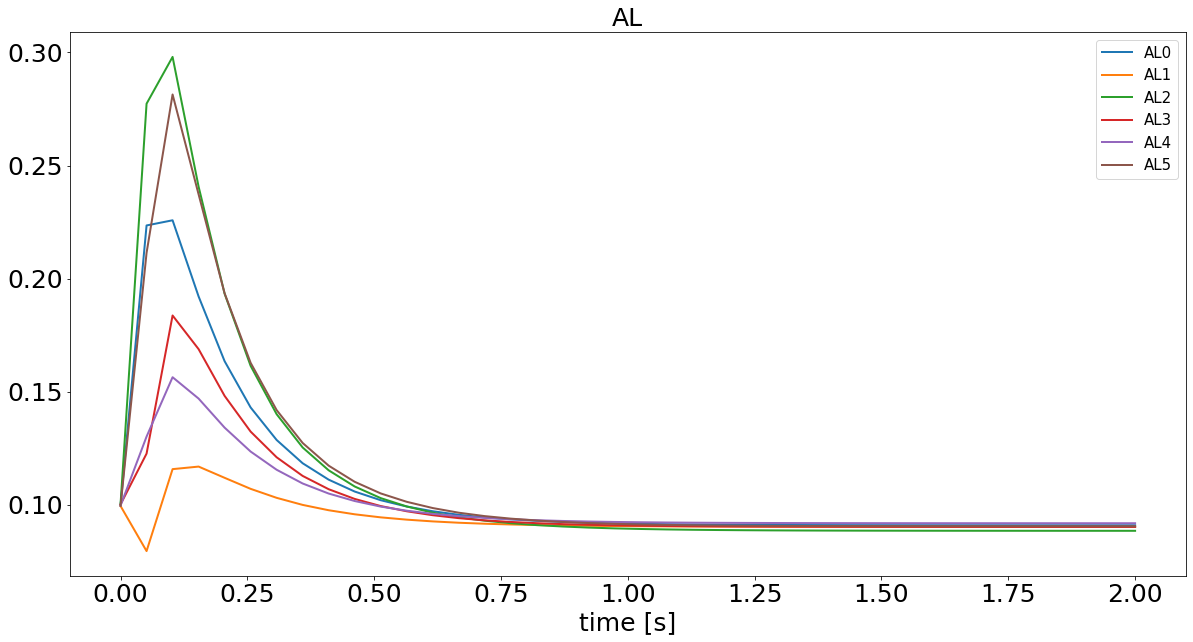

In [42]:
data = ad0[0]
times = t0
C_fig = plt.figure(figsize=(20,10))
SYNE_data = np.array(data[SYNE])
SYNI_data = np.array(data[SYNI])
plt.plot(times, SYNE_data.transpose(), linewidth=2)
plt.plot(times, SYNI_data.transpose(), '--')
C_legends = ['SYNE'+str(i) for i in range(len(SYNE))]
C_legends += ['SYNI'+str(i) for i in range(len(SYNI))]
plt.legend(C_legends, fontsize=15)
plt.title('C', fontsize=25)
plt.xlabel('time [s]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

AL_fig = plt.figure(figsize=(20,10))
AL_data = np.array(data[AL])
plt.plot(times, AL_data.transpose(), linewidth=2)
C_legends = ['AL'+str(i) for i in range(len(AL))]
plt.legend(C_legends, fontsize=15)
plt.title('AL', fontsize=25)
plt.xlabel('time [s]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

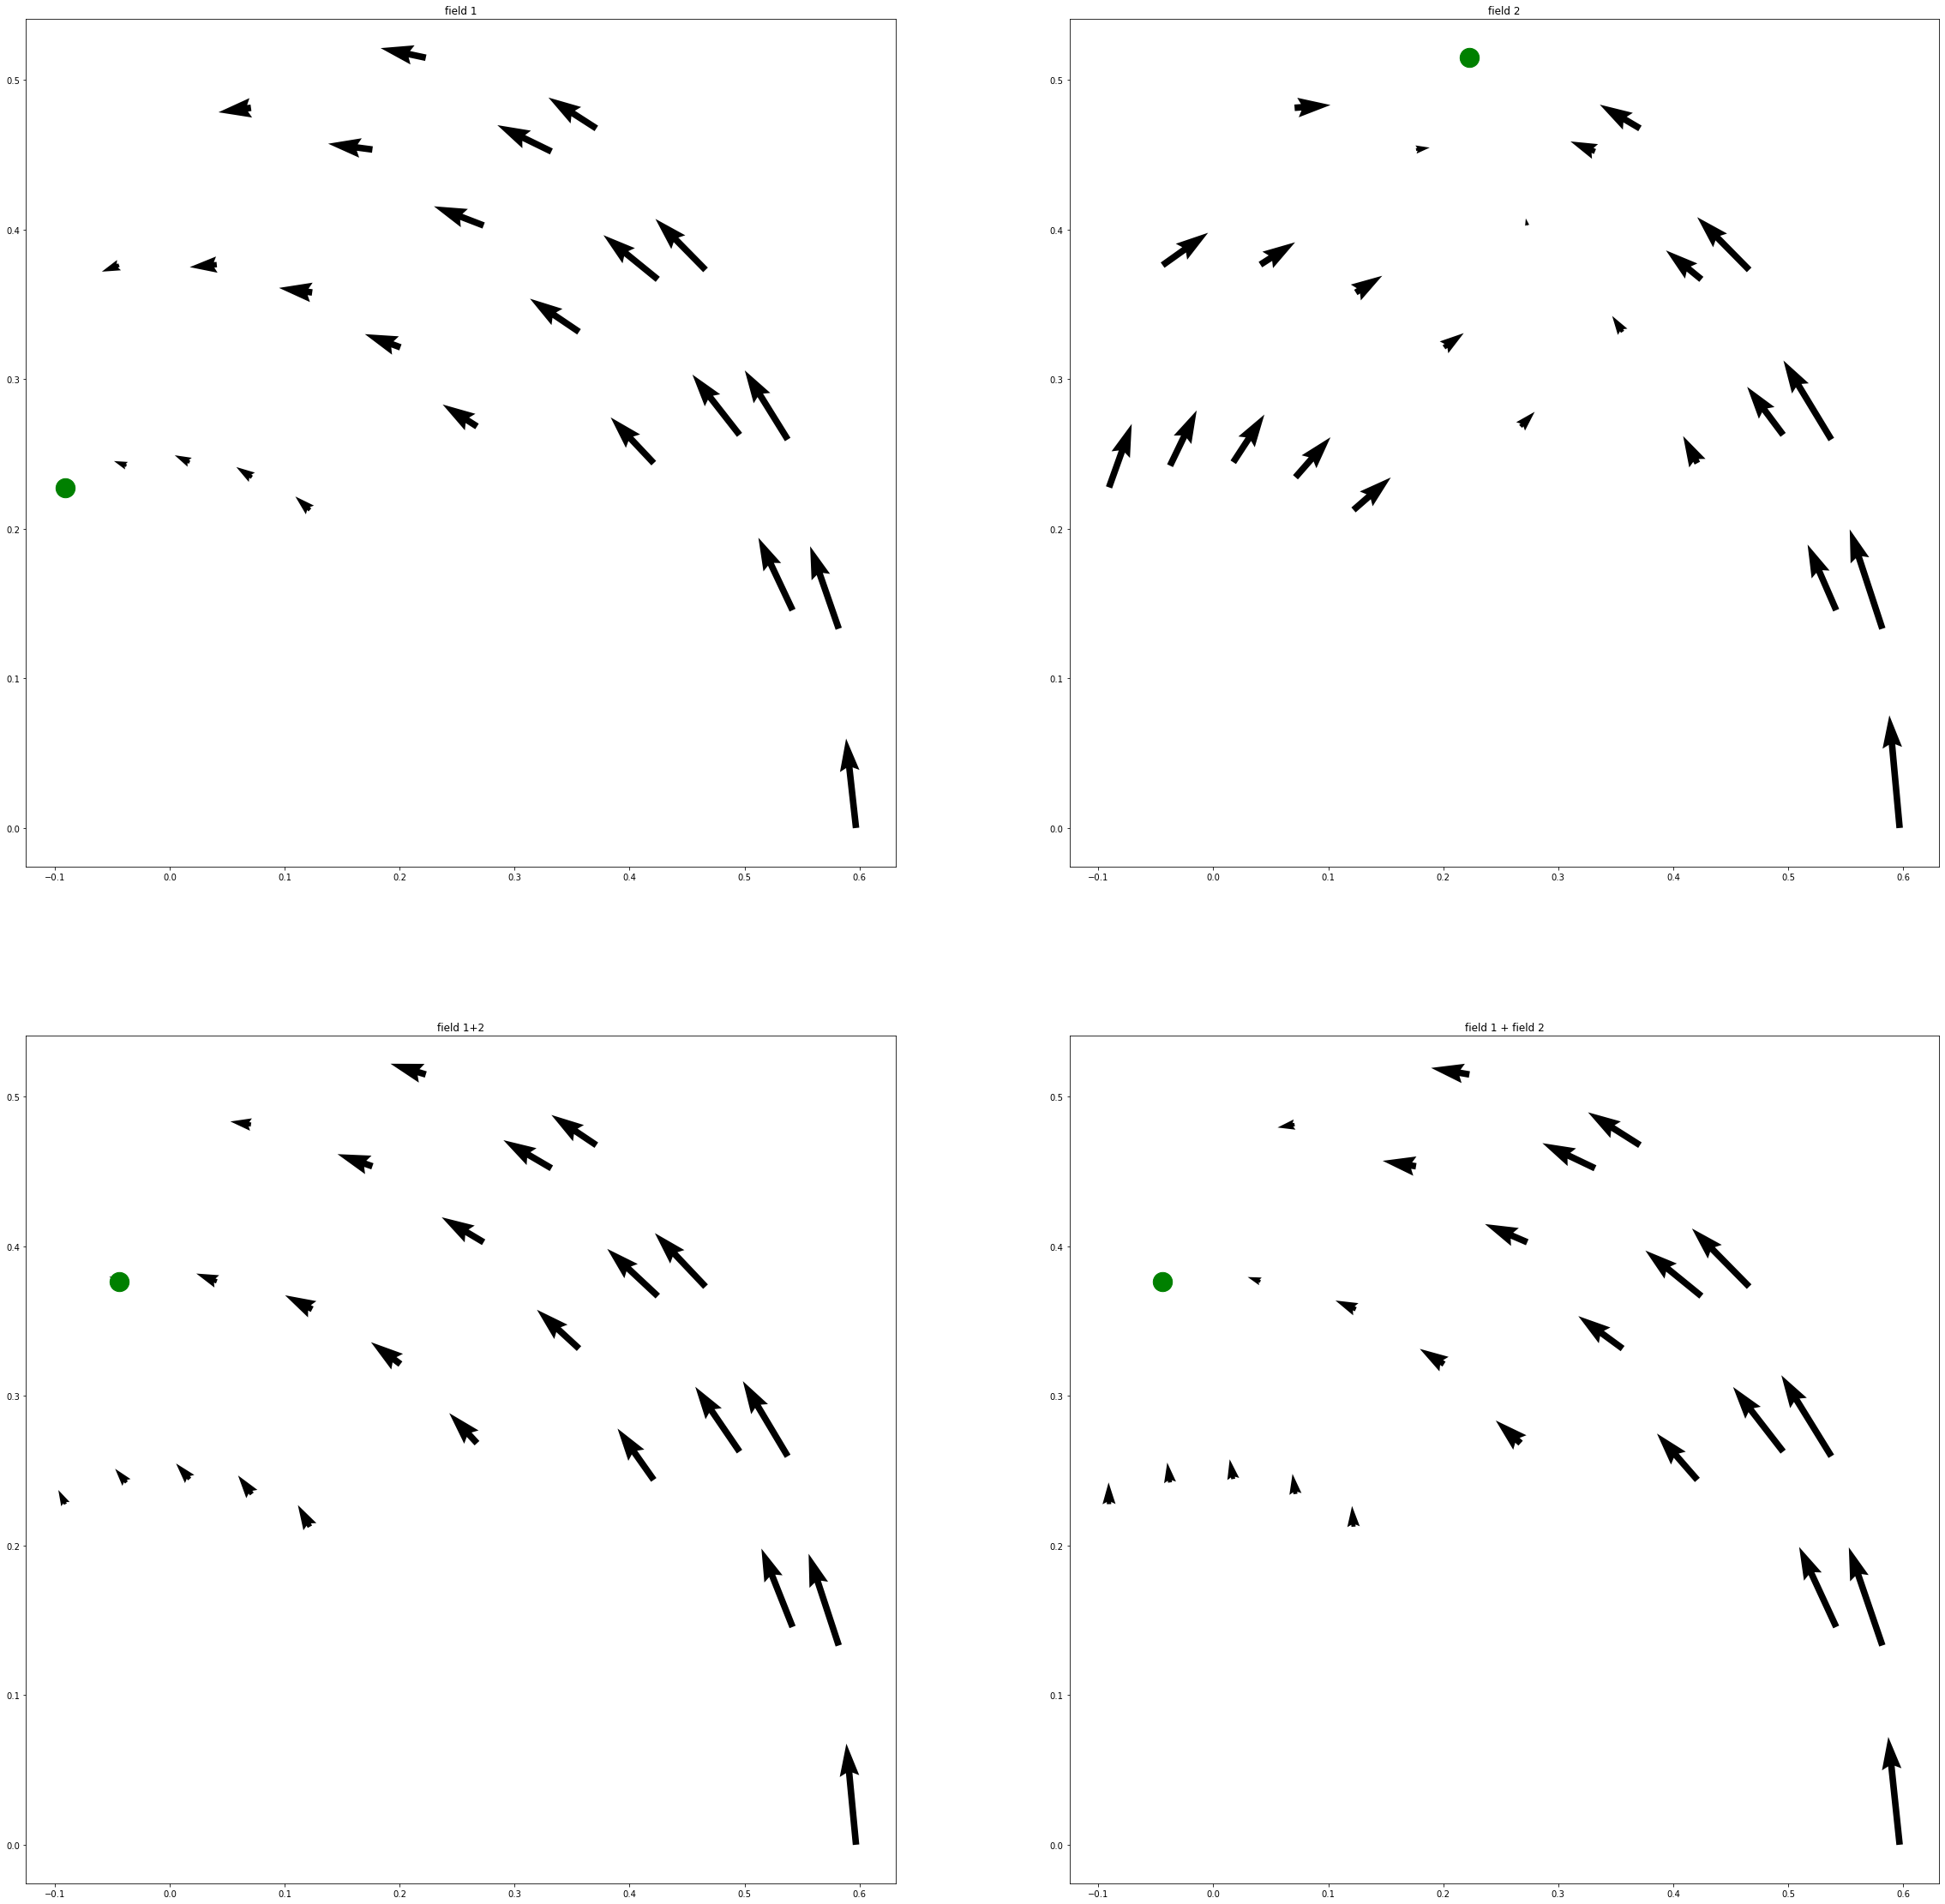

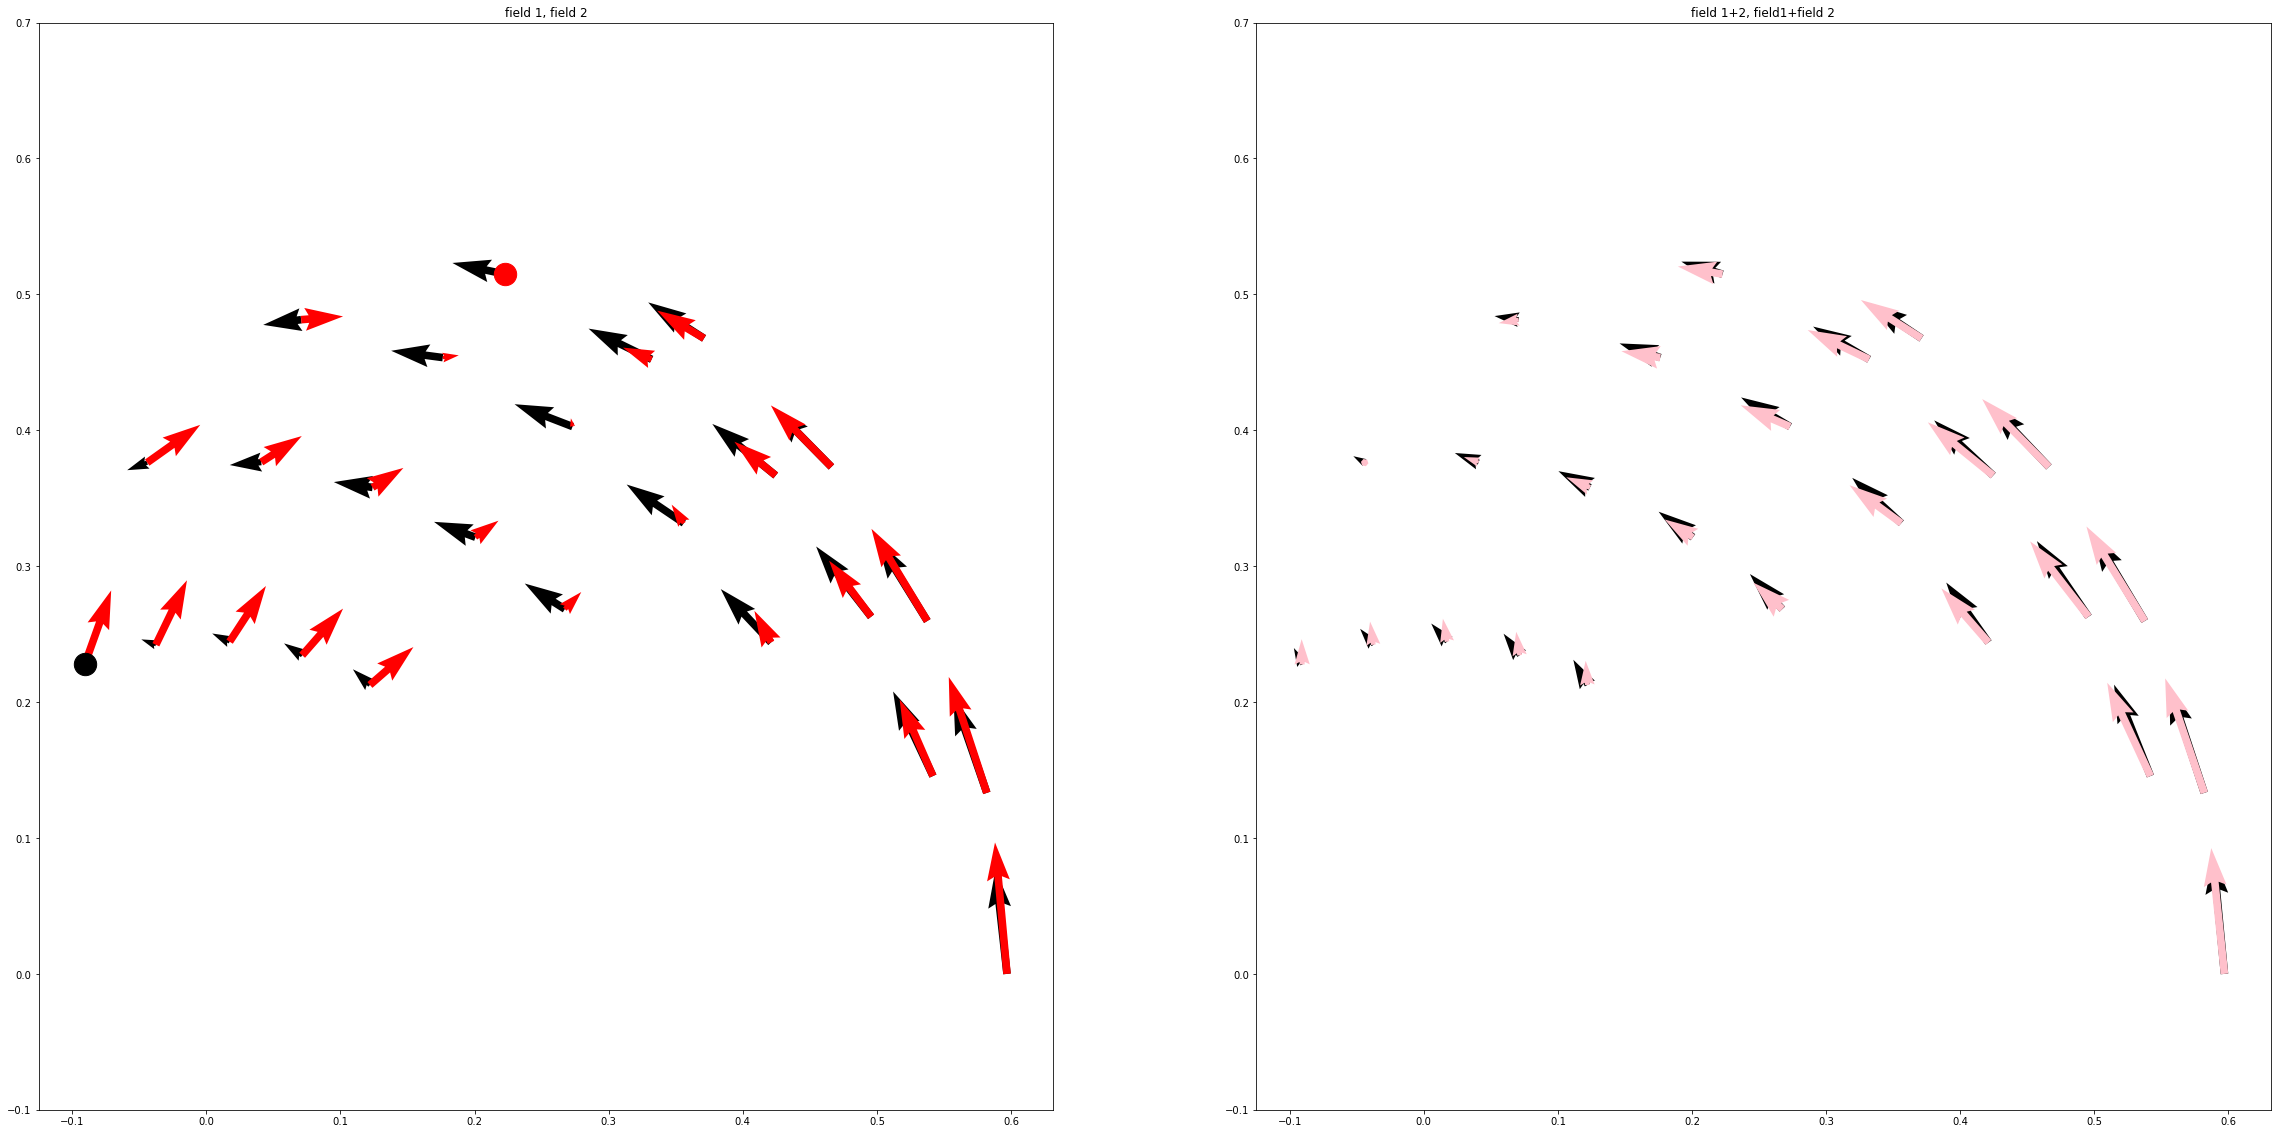

Average angle: 0.191206 radians
Average angle: 10.955278 degrees


In [43]:
# plot direction fields.
dirs0 = final_hand_coords0 - hand_coords0
dirs1 = final_hand_coords1 - hand_coords1
dirs2 = final_hand_coords2 - hand_coords2
dirs3 = final_hand_coords3 - hand_coords3
dirs4 = dirs1 + dirs2

# obtaining the coordinate with the least change for each field
min_coord0 = hand_coords0[np.argmin(np.linalg.norm(dirs0, axis=1))]
min_coord1 = hand_coords0[np.argmin(np.linalg.norm(dirs1, axis=1))]
min_coord2 = hand_coords0[np.argmin(np.linalg.norm(dirs2, axis=1))]
min_coord3 = hand_coords0[np.argmin(np.linalg.norm(dirs3, axis=1))]
min_coord4 = hand_coords0[np.argmin(np.linalg.norm(dirs4, axis=1))]

dir_fig, dir_axes = plt.subplots(2,2,figsize=(40,40))
q1 = dir_axes[0,0].quiver(hand_coords1[:,0], hand_coords1[:,1], dirs1[:,0], dirs1[:,1])
scat1 = dir_axes[0,0].scatter(min_coord1[0], min_coord1[1],  s=500, c='green')
dir_axes[0,0].set_title("field 1")
q2 = dir_axes[0,1].quiver(hand_coords2[:,0], hand_coords2[:,1], dirs2[:,0], dirs2[:,1])
scat2 = dir_axes[0,1].scatter(min_coord2[0], min_coord2[1],  s=500, c='green')
dir_axes[0,1].set_title("field 2")
q3 = dir_axes[1,0].quiver(hand_coords3[:,0], hand_coords3[:,1], dirs3[:,0], dirs3[:,1])
scat3 = dir_axes[1,0].scatter(min_coord3[0], min_coord3[1],  s=500, c='green')
dir_axes[1,0].set_title("field 1+2")
q4 = dir_axes[1,1].quiver(hand_coords2[:,0], hand_coords2[:,1], dirs4[:,0], dirs4[:,1])
scat4 = dir_axes[1,1].scatter(min_coord4[0], min_coord4[1],  s=500, c='green')
dir_axes[1,1].set_title("field 1 + field 2")

dir_fig2, dir_axes2 = plt.subplots(1,2,figsize=(40,20))
q1 = dir_axes2[0].quiver(hand_coords1[:,0], hand_coords1[:,1], dirs1[:,0], dirs1[:,1])
q1 = dir_axes2[0].quiver(hand_coords2[:,0], hand_coords2[:,1], dirs2[:,0], dirs2[:,1], color='red')
scat1 = dir_axes2[0].scatter(min_coord1[0], min_coord1[1],  s=500, c='black')
scat2 = dir_axes2[0].scatter(min_coord2[0], min_coord2[1],  s=500, c='red')
dir_axes2[0].set_title("field 1, field 2")
dir_axes2[0].set_ylim([-0.1,0.7])
q2 = dir_axes2[1].quiver(hand_coords3[:,0], hand_coords3[:,1], dirs3[:,0], dirs3[:,1], linewidth=2)
#q3 = dir_axes2[1].quiver(hand_coords3[:,0], hand_coords3[:,1], dirs4[:,0], dirs4[:,1], color='pink', scale=.1)
q3 = dir_axes2[1].quiver(hand_coords3[:,0], hand_coords3[:,1], dirs4[:,0], dirs4[:,1], color='pink')
dir_axes2[1].set_title("field 1+2, field1+field 2")
dir_axes2[1].set_ylim([-0.1,0.7])

# dir_fig2, dir_axes2 = plt.subplots(figsize=(20,10))
# q2 = dir_axes2.quiver(hand_coords3[:,0], hand_coords3[:,1], dirs3[:,0], dirs3[:,1])
# q3 = dir_axes2.quiver(hand_coords3[:,0], hand_coords3[:,1], dirs4[:,0], dirs4[:,1], color='pink', scale=.17)
# dir_axes2.set_title("field 1+2, field1+field 2")
# dir_axes2.set_ylim([-0.1,0.7])
plt.show()

# obtain a similarity measure of fields 3 and 4 (average angle)
# 1) normalize the direction vectors
norm_dirs3 = np.zeros_like(dirs3)
for idx, vec in enumerate(dirs3):
    norm_dirs3[idx, :] = vec / np.linalg.norm(vec)
norm_dirs4 = np.zeros_like(dirs4)
for idx, vec in enumerate(dirs4):
    norm_dirs4[idx, :] = vec / np.linalg.norm(vec)
# 2) Obtain the dot products between normalized vectors
dps = np.sum(norm_dirs3*norm_dirs4, axis=1)
# 3) Obtain the average angle
angs = np.arccos(dps)
avg_ang = angs.sum()/angs.size
print("Average angle: %f radians" % (avg_ang))
print("Average angle: %f degrees" % (180.*avg_ang/np.pi))

---
---
---
---

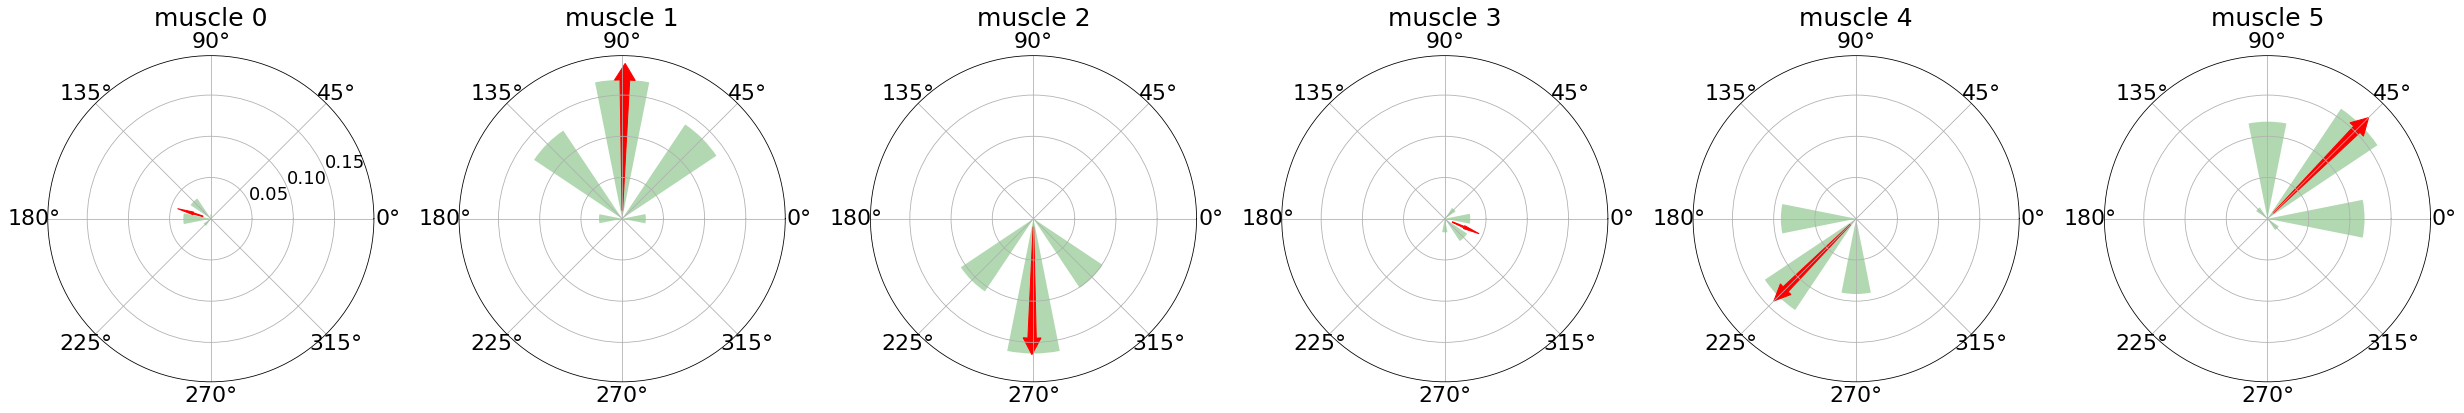

In [112]:
# Plot fracation of resting length needed to reach each target
r = 0.1
n_trgs = 8
center = np.array([0.3, 0.3]) # initial hand location
angs = np.linspace(0., 2.*np.pi, n_trgs+1)[:-1]
circle = np.array([np.array([np.cos(ang),np.sin(ang)]) for ang in angs])
targets = center + r*circle # coordinates of the targets

# obtain muscle lengths at all targets
m_lengths = np.zeros((6,8))
for tidx, target in enumerate(targets):
    net, pops_dict = create_net(target)
    plant = net.plants[pops_dict['P']]
    plant.upd_ip()
    lengths, speeds = plant.muscle_kinematics(0., 0., plant.c_elbow, plant.ip)
    m_lengths[:,tidx] = lengths

# lengths at center
c_net, c_pops_dict = create_net(center)
c_plant = c_net.plants[c_pops_dict['P']]
c_plant.upd_ip()
c_lengths, _ = c_plant.muscle_kinematics(0., 0., c_plant.c_elbow, c_plant.ip)

# obtain length difference
len_diffs = np.zeros_like(m_lengths)
for trg_id in range(len(targets)):
    len_diffs[:,trg_id] = np.maximum(c_lengths - m_lengths[:,trg_id], 0.) / c_lengths
    #len_diffs[:,trg_id] = (c_lengths - m_lengths[:,trg_id])
    
# normalize lengths
#m_lengths = m_lengths / np.tile(np.linalg.norm(m_lengths, axis=1), (8,1)).transpose()
#m_lengths -= np.tile(np.mean(m_lengths, axis=1), (8,1)).transpose()
#m_lengths -= np.tile(np.min(m_lengths, axis=1), (8,1)).transpose()

# obtain average vectors
m_vecs = np.zeros((6,2))
m_angs = np.zeros(6)
for idx, mlen in enumerate(m_lengths):
    m_vecs[idx,0] = (mlen*np.cos(angs)).sum()
    m_vecs[idx,1] = (mlen*np.sin(angs)).sum()
    m_angs[idx] = np.arctan2(m_vecs[idx,1], m_vecs[idx,0])
m_norms = np.linalg.norm(m_vecs, axis=1)

# predicted direction vectors
ldiff_vecs = np.zeros((6,2)) # predicted direction vectors
ldiff_angs = np.zeros(6)
for idx, lds in enumerate(len_diffs):
    ldiff_vecs[idx,0] = (lds*np.cos(angs)).sum()
    ldiff_vecs[idx,1] = (lds*np.sin(angs)).sum()
    ldiff_angs[idx] = np.arctan2(ldiff_vecs[idx,1], ldiff_vecs[idx,0])
ldiff_norms = np.linalg.norm(ldiff_vecs, axis=1)

# Plot muscle lengths per target
fs = (43,6)
dir_fig, dir_axs = plt.subplots(1, 6, figsize=(fs), subplot_kw=dict(projection='polar'), sharey=True)

#span = 1.5*max(m_lengths.flatten())
theta = np.linspace(0., 2 * np.pi, 8, endpoint=False)
width = np.pi / 8

for col in range(6):
    ax = dir_axs[col]
    m_id = col
    ax.set_title("muscle %d" % (m_id), fontsize=25)
    ax.bar(theta, len_diffs[m_id, :], width=width, bottom=0.0, color='g', alpha=0.3)
    ax.arrow(ldiff_angs[m_id],.01, 0., .5*ldiff_norms[m_id], width=0.07,
        head_width=0.15, head_length=0.02, length_includes_head=True, color='r')
    #ax.bar(theta, m_lengths[m_id, :], width=width, bottom=0.0, color='g', alpha=0.3)
    #ax.arrow(m_angs[m_id],.01, 0., .5*m_norms[m_id], width=0.07,
    #     head_width=0.15, head_length=0.02, length_includes_head=True, color='r')
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_yticks([.05, .1, .15])
    
                    
plt.show()

---
---
---
---

In [5]:
# SIMPLE SIMULATION
start_time = time.time()
times, data, plant_data  = net.flat_run(100.)
#times, data, plant_data  = net.run(40.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)
#Execution time is 8.687349319458008 seconds  << before sc_inp_sum_mp, flat_run(5.)

/home/z/projects/draculab/network.py:916: UserWarning: Integration method odeint substituted by Forward Euler in some units
  ' substituted by Forward Euler in some units', UserWarning)


Execution time is 80.8308777809143 seconds


In [25]:
plant_data = all_plant_data[1]
theta_s = plant_data[:,0]
theta_e = plant_data[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# coordinates of hand and elbow    
xe = np.cos(theta_s)*l1
ye = np.sin(theta_s)*l1
xh = xe + np.cos(phi)*l2
yh = ye + np.sin(phi)*l2
print("xh[0]=%f, yh[0]=%f"%(xh[0],yh[0]))
print("xh[-1]=%f, yh[-1]=%f"%(xh[-1],yh[-1]))

xh[0]=0.596426, yh[0]=-0.029433
xh[-1]=0.583874, yh[-1]=0.043188


In [16]:
# plot direction field
dirs = final_hand_coords - hand_coords
dir_fig, dir_ax = plt.subplots((2,1),figsize=(15,25))
q = dir_ax.quiver(hand_coords[:,0], hand_coords[:,1], dirs[:,0], dirs[:,1])
plt.show()

NameError: name 'final_hand_coords' is not defined

In [9]:
# obtain a similarity measure of fields 3 and 4 (average angle)
# 1) normalize the direction vectors
norm_dirs3 = np.zeros_like(dirs3)
for idx, vec in enumerate(dirs3):
    norm_dirs3[idx, :] = vec / np.linalg.norm(vec)
norm_dirs4 = np.zeros_like(dirs4)
for idx, vec in enumerate(dirs4):
    norm_dirs4[idx, :] = vec / np.linalg.norm(vec)
# 2) Obtain the dot products between normalized vectors
dps = np.sum(norm_dirs3*norm_dirs4, axis=1)
# 3) Obtain the average angle
angs = np.arccos(dps)
avg_ang = angs.sum()/angs.size
print("Average angle: %f radians" % (avg_ang))
print("Average angle: %f degrees" % (180.*avg_ang))

Average angle: 0.008224 radians
Average angle: 1.480311 degrees


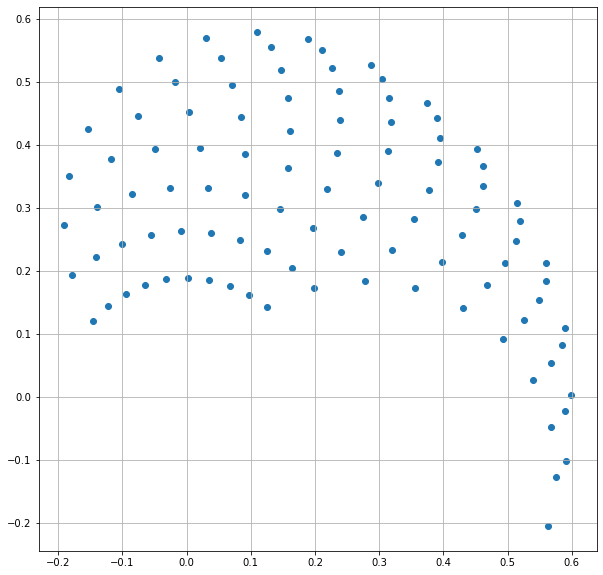

In [11]:
# plot da grid
grid_fig = plt.figure(figsize=(10,10))
plt.scatter(hand_coords0[:,0], hand_coords0[:,1])
plt.grid()
plt.show()

In [18]:
CI_data.shape

(6, 20)

shoulder angle: -0.188703, shoulder vel: 0.211702


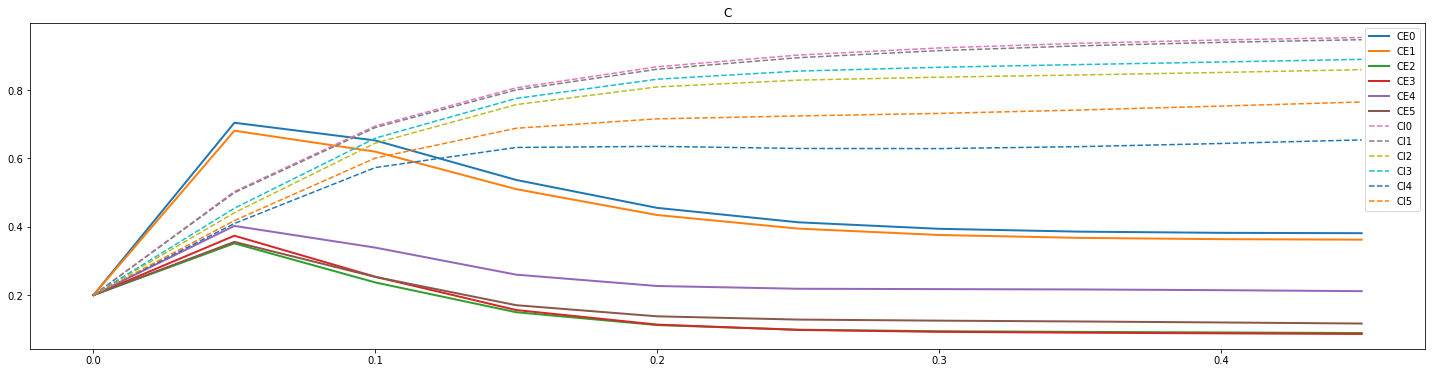

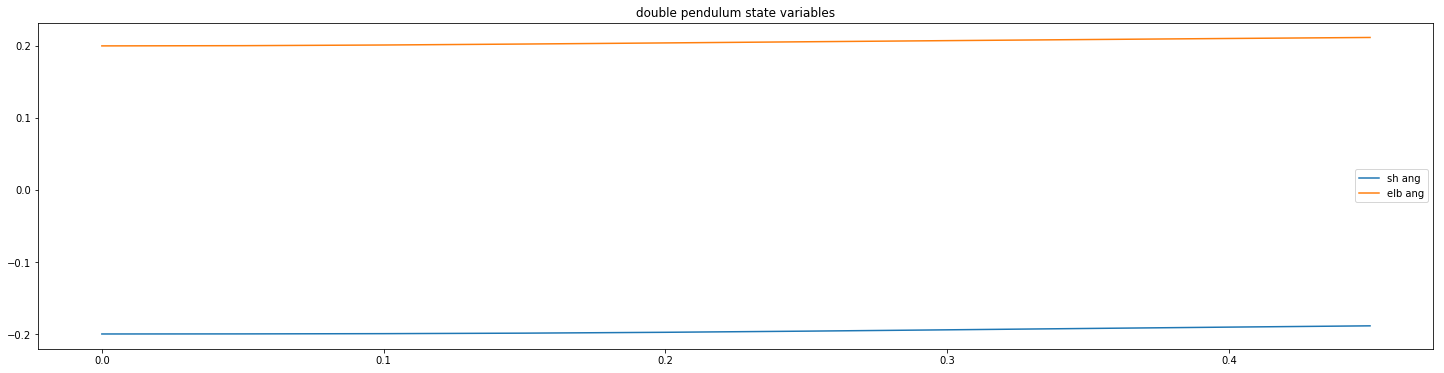

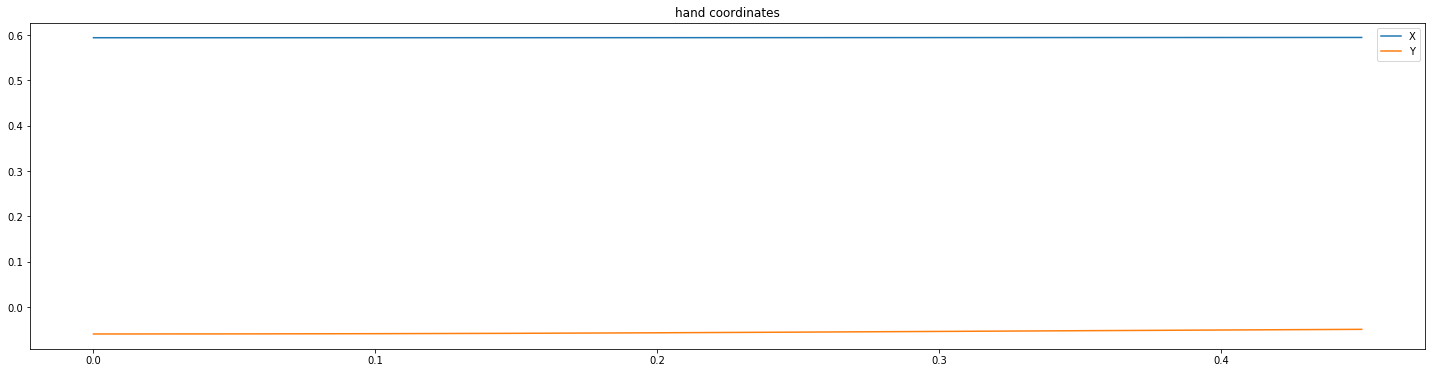

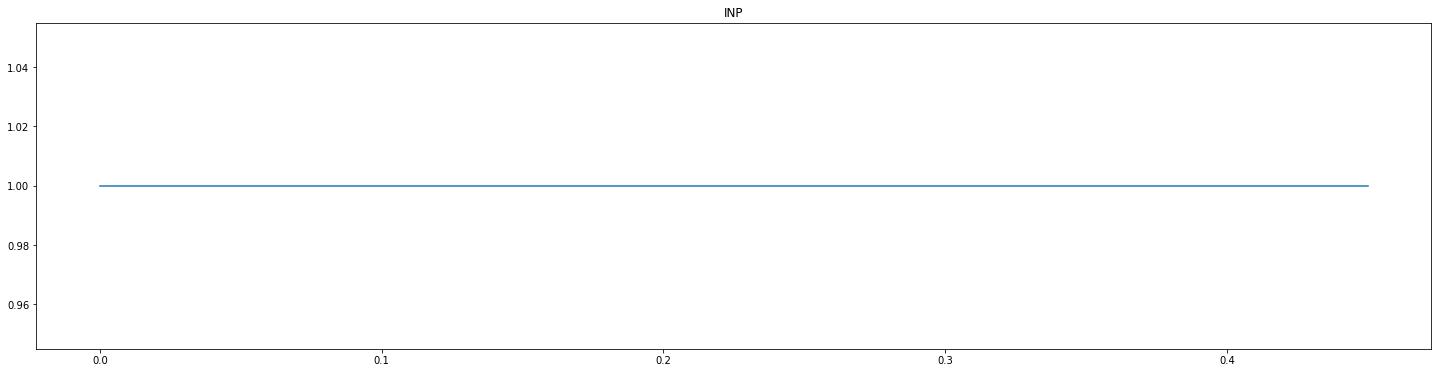

In [14]:
# plotting some unit activities
net, pops_dict = create_net([0.3,0.3])
for name in list(pops_dict.keys()):
    exec("%s = %s"% (name, str(pops_dict[name])))

field = 2 # for which set of simulations (for which stimulus)
grid_point = 0 # for which grid point
ad = [ad0, ad1, ad2, ad3]
apd = [apd0, apd1, apd2, apd3]
plant_data = apd[field][grid_point]
arm_activs = plant_data
data = ad[field][grid_point]
times = t0 # all times grids should be equal

fs = (25,6)
# C
C_fig = plt.figure(figsize=fs)
CE_data = np.array(data[CE])
CI_data = np.array(data[CI])
plt.plot(times, CE_data.transpose(), linewidth=2)
plt.plot(times, CI_data.transpose(), '--')
C_legends = ['CE'+str(i) for i in range(len(CE))]
C_legends += ['CI'+str(i) for i in range(len(CI))]
plt.legend(C_legends)
plt.title('C')

# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[:,0:4:2]
plt.plot(times, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',])
plt.title('double pendulum state variables')
print("shoulder angle: %f, shoulder vel: %f" % (P_state[-1,0],P_state[-1,1]))

plant = net.plants[P]
# modified copy-paste of plt.upd_ip_impl
q1 = arm_activs[:,0]
q2 = arm_activs[:,2]
q12 = q1+q2
c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                   c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
coords_fig = plt.figure(figsize=fs)
plt.plot(times, c_hand)

plt.title('hand coordinates')
plt.legend(['X', 'Y'])

inp_fig = plt.figure(figsize=fs)
inp_data = np.array(data[INP])[0]
plt.plot(times, inp_data)
#plt.plot(times, 0.8*np.ones_like(times), 'k--')
plt.title('INP')

plt.show()

AL_data:
[0.09010397 0.08819104 0.06213293 0.05840994 0.1134972  0.07870043]
Ib avg for muscle 0= 0.1990391556272762
Ia avg for muscle 0= 0.16861180910039542
II avg for muscle 0= 0.406942439823315
Ib avg for muscle 1= 0.18588051971740427
Ia avg for muscle 1= 0.15953966196958244
II avg for muscle 1= 0.32483802453259103
Ib avg for muscle 2= 0.10989569980395439
Ia avg for muscle 2= 0.060791557740649704
II avg for muscle 2= 0.14633777811628595
Ib avg for muscle 3= 0.06986969753273825
Ia avg for muscle 3= 0.049358456396335
II avg for muscle 3= 0.1639354236779818
Ib avg for muscle 4= 0.19532243822829534
Ia avg for muscle 4= 0.286110196382055
II avg for muscle 4= 0.5123391091306574
Ib avg for muscle 5= 0.13113995048449079
Ia avg for muscle 5= -0.02952744606357981
II avg for muscle 5= 0.01305896935481872


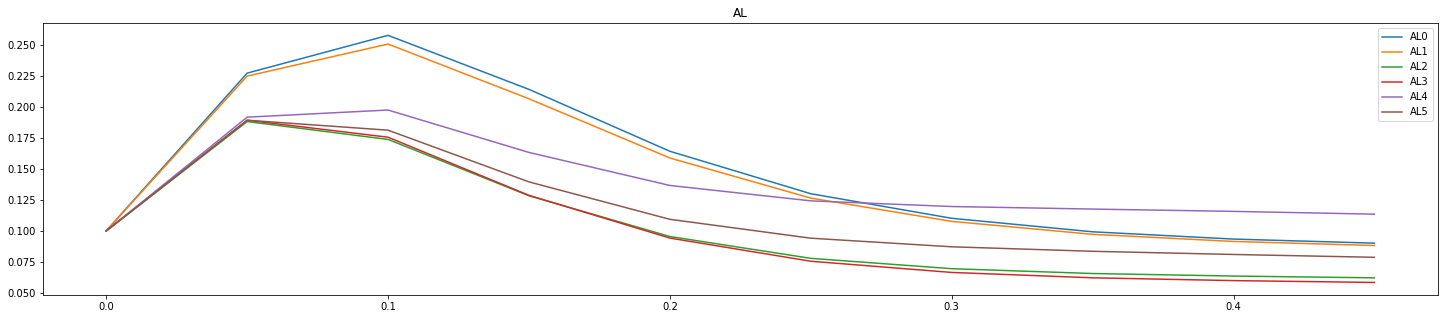

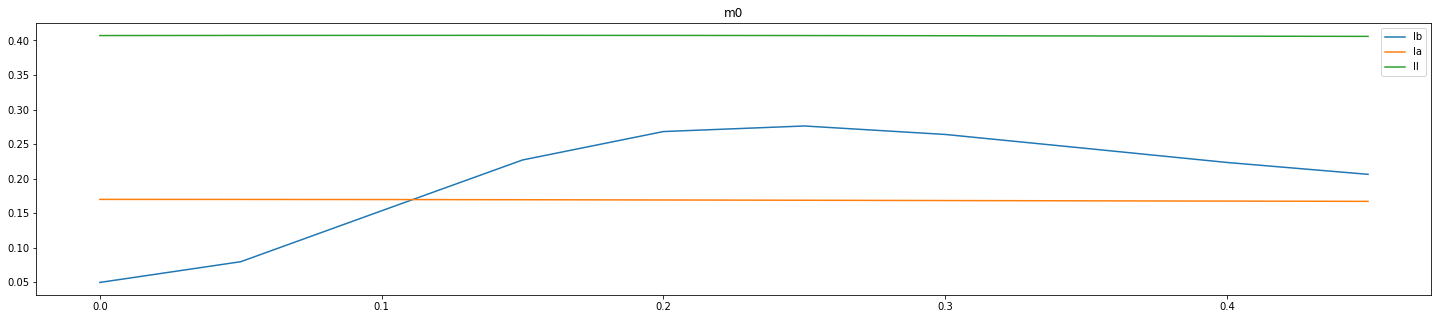

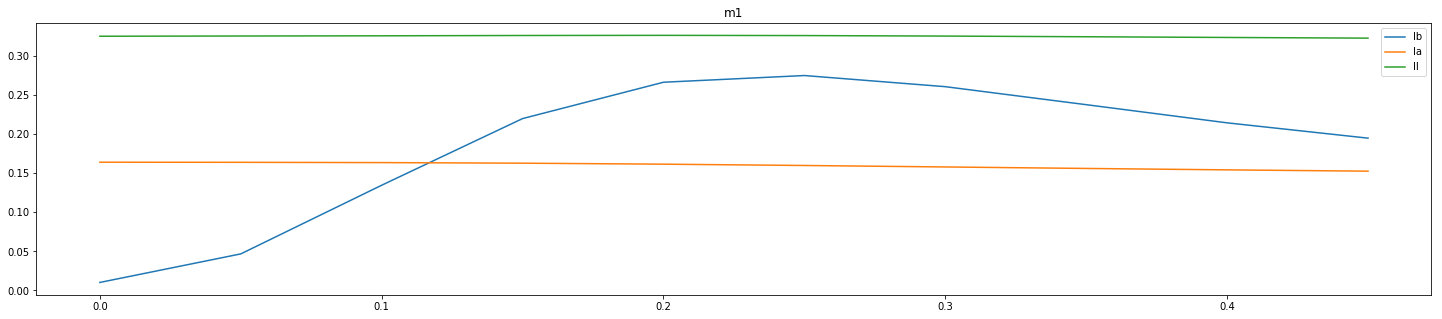

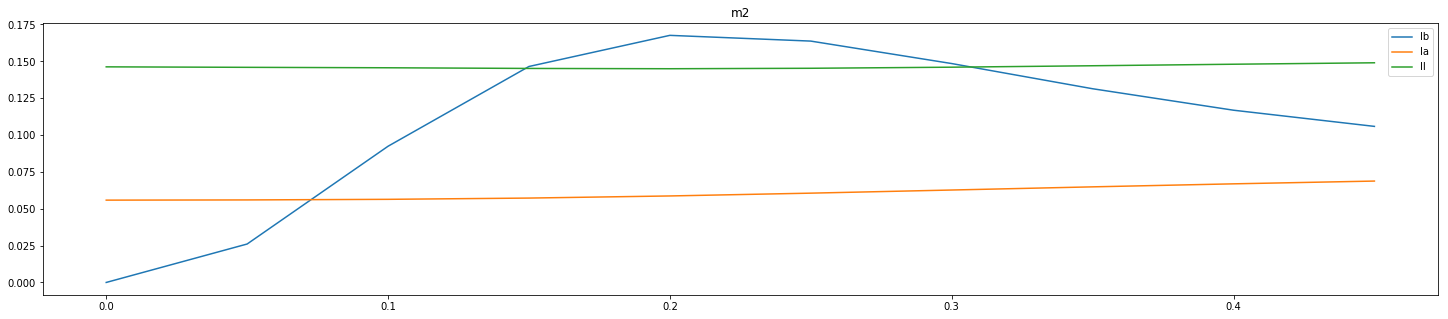

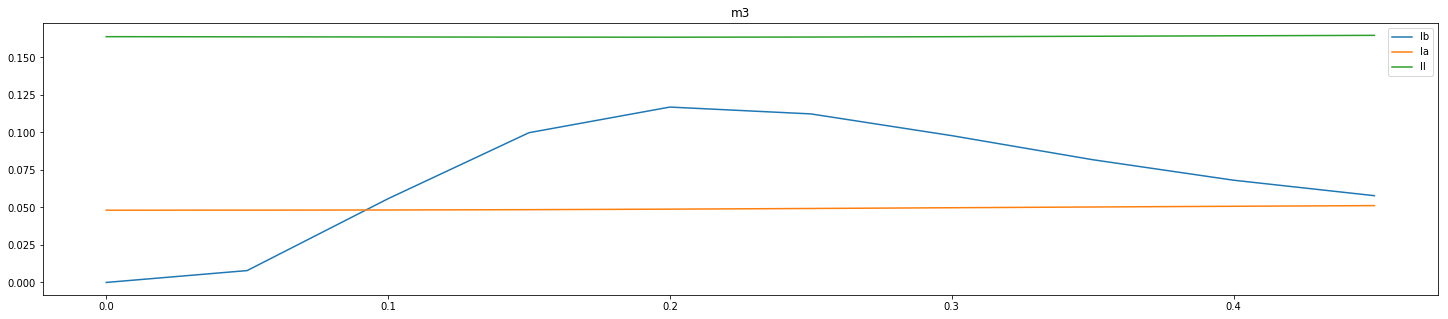

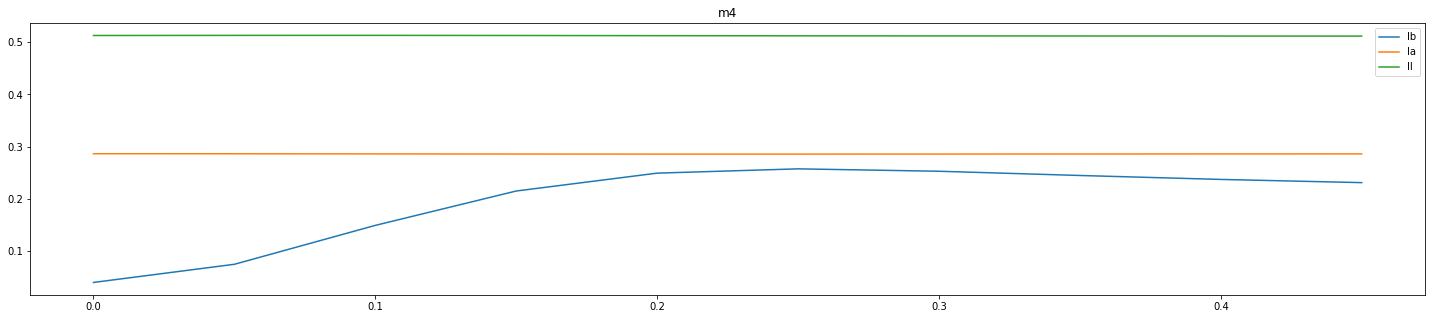

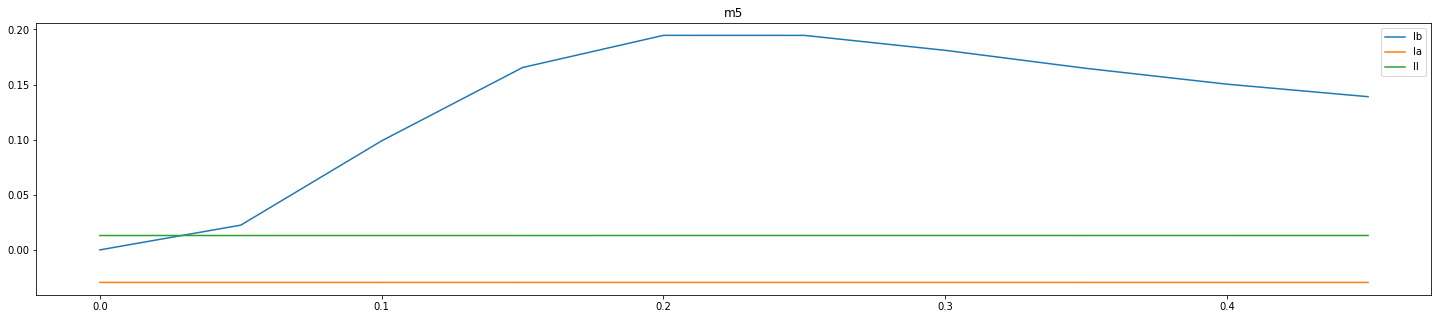

In [15]:
# Alpha units
fs2 =(25,5)
AL_fig = plt.figure(figsize=fs2)
AL_data = np.array(data[AL])
plt.plot(times, AL_data.transpose())
AL_legends = ['AL'+str(i) for i in range(len(AL))]
plt.legend(AL_legends)
plt.title('AL')
print('AL_data:')
print(AL_data[:,-1])

# plotting muscle outputs
#fs = (20,5)
legs = ['Ib', 'Ia', 'II']

for i in range(6):
    next_fig = plt.figure(figsize=fs2)
    Ib = arm_activs[:,22+i]
    Ia = arm_activs[:,28+i]
    II = arm_activs[:,34+i]
    plt.plot(times, Ib, times, Ia, times, II)
    #plt.plot(times, Ib)
    plt.legend(legs)
    plt.title('m' + str(i))
    print('Ib avg for muscle '+ str(i) + '= ' + str(np.mean(Ib)))
    print('Ia avg for muscle '+ str(i) + '= ' + str(np.mean(Ia)))
    print('II avg for muscle '+ str(i) + '= ' + str(np.mean(II)))
plt.show()

---

In [32]:
#Animation of the arm and muscles
%matplotlib widget
from numpy import cos, sin
from matplotlib.animation import FuncAnimation

arm_activs = plant_data[0]
#arm_activs = all_plant_data[3]
# angles of shoulder and elbow
theta_s = arm_activs[:,0]
theta_e = arm_activs[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
acts = np.array(data[1])
ipx = data[ipx_track]
ipy = data[ipy_track]
ten = arm_activs[:, np.array(range(4,10))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2
# creating the figure and axis
fig = plt.figure(figsize=(8,8))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.grid()
# creating lines and points
line, = ax.plot([], [], 'o-b', lw=2)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
# preparing a colormap for the tensions
ten_max = max(ten.max(), 1e-5)
ten_min = min(ten.min(), -1e-5)
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
strt_idx = int(np.round(times[0]/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = frame*net.min_delay
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    # plotting target
    cur_idx = int(cur_time/t_pres) + strt_idx
    x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
    target.set_data([x_coord], [y_coord])
    
    return line, points, mus_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 20), init_func=init, blit=True, interval=20)

plt.show()

IndexError: too many indices for array

In [9]:
# checking some connections

print("Connections to spinal units")
for idx, syn in enumerate(net.syns[CE[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in INP:
        pre_pop = 'INP'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CE, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")

for idx, syn in enumerate(net.syns[CI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in INP:
        pre_pop = 'INP'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CI, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")


print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in AL:
        pre_pop = 'AL'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
print("-------------------------\n")



Connections to spinal units
0) CI (12) --> CE, w=-4.000000, port=2, plant_out=None
1) CE (7) --> CE, w=0.500000, port=1, plant_out=None
2) CI (13) --> CE, w=0.000000, port=2, plant_out=None
3) CE (8) --> CE, w=0.000000, port=1, plant_out=None
4) CI (14) --> CE, w=0.000000, port=2, plant_out=None
5) CE (9) --> CE, w=0.000000, port=1, plant_out=None
6) CI (15) --> CE, w=0.000000, port=2, plant_out=None
7) CE (10) --> CE, w=0.500000, port=1, plant_out=None
8) CI (16) --> CE, w=0.000000, port=2, plant_out=None
9) CE (11) --> CE, w=0.000000, port=1, plant_out=None
10) CI (17) --> CE, w=0.000000, port=2, plant_out=None
11) INP (18) --> CE, w=0.000000, port=0, plant_out=None
-------------------------

0) CE (6) --> CI, w=1.000000, port=2, plant_out=None
1) CE (7) --> CI, w=0.000000, port=2, plant_out=None
2) CI (13) --> CI, w=0.000000, port=1, plant_out=None
3) CE (8) --> CI, w=0.500000, port=2, plant_out=None
4) CI (14) --> CI, w=0.000000, port=1, plant_out=None
5) CE (9) --> CI, w=2.000000,

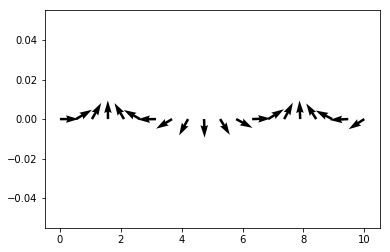

In [10]:
x = np.linspace(0,10,20)
y = np.zeros_like(x)
u = np.cos(x)
v = np.sin(x)
fig, ax = plt.subplots()
#q = ax.quiver(X, Y, U, V)
q = ax.quiver(x,y,u,v)
plt.show()

In [5]:
# SIMPLE SIMULATION
net.plants[0].place_hand([0.5, 0.15])
start_time = time.time()
times, data, plant_data  = net.flat_run(50.)
#times, data, plant_data  = net.run(40.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)
#Execution time is 8.687349319458008 seconds  << before sc_inp_sum_mp, flat_run(5.)

/home/z/projects/draculab/network.py:916: UserWarning: Integration method odeint substituted by Forward Euler in some units
  ' substituted by Forward Euler in some units', UserWarning)


Execution time is 53.31408667564392 seconds
